# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def sns_joint_equal_axes(g):
    
    g.ax_joint.set_aspect('equal')
    
    # Get the position of the joint plot and marginal plots
    joint_position = g.ax_joint.get_position()
    xmarg_position = g.ax_marg_x.get_position()
    ymarg_position = g.ax_marg_y.get_position()

    # Set the position and size of the x-axis marginal plot
    g.ax_marg_x.set_position([xmarg_position.x0, joint_position.y1 + 0.02, joint_position.width, xmarg_position.height])

    # Set the position and size of the y-axis marginal plot
    g.ax_marg_y.set_position([ymarg_position.x0, joint_position.y0, ymarg_position.width, joint_position.height])
    
    return g


def pairwise_distances(df, target_ids, dimensions = ['soma_x', 'soma_y_adj', 'soma_z'], source_ids = None, source_coords = None):
    # Extract source coordinates
    if source_ids is not None:
        # source_ids is a tuple of ('column_name',[column_values])
        source_coords = df[df[source_ids[0]].isin(source_ids[1])].loc[:, dimensions].values
    
    # Extract target coordinates
    # target_ids is a tuple of ('column_name',[column_values])
    target_coords = df[df[target_ids[0]].isin(target_ids[1])].loc[:, dimensions].values

    # Handle NaN values
    source_coords = np.nan_to_num(source_coords, nan=np.nan)
    target_coords = np.nan_to_num(target_coords, nan=np.nan)

    # Calculate pairwise distances
    distances = np.linalg.norm(source_coords - target_coords, axis=-1)
    
    return distances

## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

# Molecular layer fit

In [4]:
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

In [5]:
# Define mathematical function for curve fitting 
def func(xy, a, b, c, d, e, f, g, h):  # #h):#
    x, y = xy 
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x**3 + g*y**3 + h*x*y # + h*x*y #

In [6]:
Path(settings_dict['save_dir']).parent.parent

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome')

In [7]:
neuroglancer_path = Path(settings_dict['save_dir']).parent.parent / 'Krista/blender/soma_locations/layer-molecular_annotation.json'
voxel_sizes = [16,16,30]
nl_ = 'molecular'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)
    
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']]

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

In [8]:
# Perform curve fitting 
popt, pcov = curve_fit(func, (x_pts, z_pts), y_pts) 
  
# Print optimized parameters 
print(popt) 

[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



# Load files

## mg_network file names

In [9]:
dirpath = Path(settings_dict['save_dir'])


In [10]:
nodefiles = get_cell_filepaths(dirpath)

In [11]:
len(nodefiles)

3799

## df_syn pre or post

In [185]:
df_syn = pd.read_csv(dirpath / 'graphs/df_presyn.csv')
syn = 'pre-synaptic'

In [99]:
df_syn.head()

Unnamed: 0        pre       post structure       x       y      z pre_type  \
0           0  126649726  305329558      axon  333376  306304  50700      mg2   
1           1  126649726  221714230      axon  341472  295248  37110      mg2   
2           2  126649726  302730452      axon  229456  307280  52860      mg2   
3           3  126649726   44244249      axon  337200  270496  19050      mg2   
4           4  126649726  559551706      axon  322752  307680  65130      mg2   

  post_type  
0       sg1  
1     grc-s  
2       sg1  
3     grc-s  
4       sg1

In [186]:
df_syn.loc[df_syn['post_type'].isin(['dml']),'post_type']='mli'

df_syn.loc[df_syn['pre_type'].isin(['dml']),'pre_type']='mli'

In [187]:
if syn == 'pre-synaptic':
    df_syn.drop(df_syn[df_syn['pre'].isin([50786130, 474836942, 303892282])].index, inplace=True)



In [188]:
# df_syn.loc[df_syn['pre']==285761792,'pre_type']='pe'

### --> df_edges

In [189]:
# remove structure and soma diameter information if want to
df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1) # 

In [190]:
df_edges=df_syn.value_counts().reset_index(name='weight')

In [191]:
df_edges.loc[:,'post_type'] = [t.lower() for t in df_edges['post_type']]
df_edges.loc[:,'pre_type'] = [t.lower() for t in df_edges['pre_type']]

In [20]:
df_edges[df_edges['pre_type'].isin(['tsd'])].groupby('post_type').count()

Empty DataFrame
Columns: [pre, post, pre_type, weight]
Index: []

In [194]:
df_edges[(df_edges['pre_type'].isin(['lg']))&(df_edges['post_type'].isin(['uk']))]['post'].unique()

array([223912857,  53338888, 135791700, 218201918,  48775604, 139183144,
       134663815, 134662203,  46484343,  46485398])

In [331]:
df_edges[df_edges['pre_type'].isin(['mg1'])]

pre       post pre_type post_type  weight
78    299439953  214827705      mg1       sg2       6
79    299439953  213605530      mg1       mg2       6
93    299496636  387382792      mg1       sg2       6
108   299496636  313190713      mg1     grc-d       5
136   299496636  225105062      mg1     grc-d       5
...         ...        ...      ...       ...     ...
2158  299496636  220723211      mg1       sg2       1
2159  299496636  220336851      mg1       sg2       1
2160  299496636  220259817      mg1       sg2       1
2161  299496636  218095913      mg1       sg2       1
2162  299496636  218063304      mg1       fov       1

[456 rows x 5 columns]

## Combined df_syn

In [11]:
df_post = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
df_pre = pd.read_csv(dirpath / 'graphs/df_presyn.csv')



In [12]:
df_pre.loc[df_pre['post_type'].isin(['dml']),'post_type']='mli'
df_pre.loc[df_pre['pre_type'].isin(['dml']),'pre_type']='mli'
df_post.loc[df_post['post_type'].isin(['dml']),'post_type']='mli'
df_post.loc[df_post['pre_type'].isin(['dml']),'pre_type']='mli'

In [13]:
df_pre = df_pre.rename(columns={'pre':'post','post':'pre','pre_type':'post_type','post_type':'pre_type'})

## --> df_edges

In [14]:
df_edges_pre=df_pre.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

df_edges_post=df_post.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

In [15]:
df_edges = deepcopy(df_edges_post)

## if want to keep any information that might differ between the two dataframes, use the following code first to rename columns in df_edges_pre to match df_edges
# df_edges_pre = df_edges_pre.rename(columns={'pre_type': 'pre_type_x', 'post_type': 'post_type_x', 'weight': 'weight_x'})

# Than use combine_first to merge the DataFrames
df_edges = df_edges_post.set_index(['pre', 'post']).combine_first(df_edges_pre.set_index(['pre', 'post'])).reset_index()

In [16]:
df_edges.loc[:,'post_type'] = [t.lower() for t in df_edges['post_type']]
df_edges.loc[:,'pre_type'] = [t.lower() for t in df_edges['pre_type']]

In [17]:
# Display the final DataFrame
df_edges.head(4)

pre       post post_type pre_type  weight
0  23379765  128832297       sg1       pe       1
1  23379765  218095913       sg2       pe       1
2  23379765  299496636       mg1       pe       2
3  23379765  305051491     grc-s       pe       1

# export synapse locations to xyz file for blender

In [509]:
soma_pts[0][0]

245690.0

In [428]:
ctype = 'mg2'
df_syn[(df_syn['pre'].isin([299496636])) & (df_syn['post_type'].isin([ctype]))].groupby(['post']).count().sort_values('pre').index

Index([ 42015852, 129030308, 214581797, 300689181, 386300356, 474839189,
       558300217, 646634295,  40665046, 472051969, 472284925, 472361842,
       386392158, 472517114],
      dtype='int64', name='post')

In [362]:
# ctype = ['sg1','aff','grc-s','mg1']
ctype = ['sg2','grc-d','mg2']

scale_factor = 100000

yaxis_replace_scale = 32768*16/scale_factor
zaxis_replace_scale = 3500*30/scale_factor
refpt = [0,0,0]

for c_ in ctype:
    _pts = df_syn[(df_syn['pre'].isin([299496636])) & (df_syn['post_type'].isin([c_]))][['x','y','z']].values #299496636 mg1  #214581797 mg2
        
    vertices = [[(v[0]-refpt[0])/scale_factor,
         (v[1]-refpt[1])/scale_factor,
         (v[2]-refpt[2])/scale_factor] for v in _pts]
    vertices = [[v[0],yaxis_replace_scale-v[1],-v[2]] for v in vertices] #in this case, the z needed to be mirrored (not sure why did not need to do for cells to blender)
        

    fullpath = f'/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Krista/blender/sensory-input_mg1-299496636/{c_}_syn.xyz'
    with open(fullpath, 'w') as file:
        for v in vertices:
    
           # file.write(f'{s[0]},{s[1]},{s[2]}\n')
            file.write("{}\t {}\t {}\n".format(v[0],v[2],v[1]))

# shuffle synaptic connection dataframe

In [ ]:
df1 = df_syn.sample(frac = 1).reset_index()
display(df1)

df_syn.loc[df1['index'],['post']] = df1['post']
df_syn.loc[df1['index'],['post_type']] = df1['post_type']

# cell types for all files in directory

In [112]:
nodefiles = get_cell_filepaths(Path(settings_dict['save_dir'])) 

In [113]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[x]=''
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        

the following cells are not typed in the main network
['137913766']


In [115]:
df_type = pd.DataFrame(cell_type.items(),columns = ['id','type'])

In [117]:
for ctype in ['aff','grc-d','grc-s','sgx1','sgx2','sg1','sg2','mg1','mg2','lg','lf','uk','tsd']:
    all_mg = set([int(id_) for id_ in df_type[df_type['type'].isin([ctype])]['id'].values])
    print(f'{len(all_mg)} {ctype}')

# ctype = 'mg1'
# all_mg = set([int(id_) for id_ in df_type[df_type['type'].isin([ctype])]['id'].values])
# print(f'{len(all_mg)} mg1')

38 aff
465 grc-d
115 grc-s
88 sgx1
40 sgx2
301 sg1
157 sg2
61 mg1
59 mg2
41 lg
43 lf
754 uk
70 tsd


### mg without syn

In [422]:
ctype = 'mg1'

all_mg = set([int(id_) for id_ in df_type[df_type['type'].isin([ctype])]['id'].values])

syn_mg = set(df_edges[df_edges['pre_type'].isin([ctype])]['pre'].values)

In [423]:
print(f'{len(all_mg.difference(syn_mg))} without synapses labelled')
all_mg.difference(syn_mg)

11 without synapses labelled


{40508404,
 41591506,
 41748464,
 43587455,
 43590603,
 44439012,
 129604015,
 214535386,
 299405462,
 561980827,
 646633319}

mg1s without syn
 40508404: no axon,
 41591506: no axon,
 41748464: no axon,
 43587455: no axon,
 44517560: nate,
 128813171: nate, 
 129604015: no axon,
 213760634: nate,
 214411806, nate
 214535386, no axon
 215030183, nate
 216081986, nate
 298228381, nate
 299405462, no axon
 301973569, to sg1, kp
 303244291, nate
 386612701, nate
 387197529, kp
 387909811, kp
 472994717, kp
 473647416, fov
 473675810, nate
 556752337, kp
 557092670, kp
 557818053, no axon
 558360429, nate
 559551706, nate
 560744270, kp 
 560819551, kp
 561980827, no axon 
 642905044, nate
 646633319 no axon
 
 mg2s without syn
 40448913, nate
 40665046, kp
 41670234, nate
 42015852, nate
 42769344, no axon
 44098544: no axon,
 47658586, kp
 126649726: no axon,
 127607174: no axon,
 130021134: no axon,
 131137860: no axon,
 214288055, no axon
 214799314, kp
 215492896, nate
 216192012, kp
 218575005, kp
 300226567, nate
 300503092, nate
 302018917, no axon
 303166992, sg2; kp
 386300356, nate
 392411629, sg2
 472115344, nate
 477019570, to sg2, kp
 477300082: nate,
 556969316: no axon,
 558254086: no axon,
 562815622: sg2?,
 642458763: nate,
 644205547: no axon,
 644824766: nate

In [ ]:
40448913,41670234,300226567,300503092,477300082,642458763,644824766
# 40665046, kp

# Cell features to add

## Soma diameter and location

In [148]:
soma_diam = {}
soma_loc = {}
cell_type = {}
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 

    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']
        
        xpts = [p[0][0] for p in soma_anno]
        ypts = [p[0][1] for p in soma_anno]
        zpts = [p[0][2] for p in soma_anno]

        if len(soma_anno)==4:
            soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))),int((np.max(zpts)-np.min(zpts)))])
            soma_loc[x] = (np.mean([np.max(xpts),np.min(xpts)]),np.mean(ypts),np.mean([np.max(zpts),np.min(zpts)]))
            
        elif len(soma_anno)==3:
            soma_diam[x] = np.NaN
            soma_loc[x] = (np.mean([np.max(xpts),np.min(xpts)]),np.mean(ypts),np.mean([np.max(zpts),np.min(zpts)]))
            
        else:
            soma_diam[x] = np.NaN
            soma_loc[x] = (np.NaN,np.NaN,np.NaN)
    
    if 'soma' not in cell.cell_data['end_points'].keys():
        soma_diam[x] = np.NaN
        soma_loc[x] = (np.NaN,np.NaN,np.NaN)
    
    

In [149]:
df_loc = pd.DataFrame(soma_loc).T
df_loc.columns=['soma_x','soma_y','soma_z']

dict_list = [soma_diam, cell_type]

dfs = [pd.DataFrame(d.values()) for d in dict_list]

df_ = pd.concat(dfs, axis=1)

df_.columns = ['soma_diam','cell_type']
df_.index = soma_diam.keys()

df_soma = pd.concat([df_,df_loc],axis=1)

df_soma = df_soma.rename_axis('id').reset_index()

df_soma['id'] = df_soma['id'].astype('int')
df_soma = df_soma.replace([np.inf, -np.inf], np.nan)

df_soma[['soma_diam','soma_x','soma_y','soma_z']] = df_soma[['soma_diam','soma_x','soma_y','soma_z']].div(1000).round(2)

In [150]:
y_adj_col = []
for i,r in df_soma.iterrows():
    # print(i,r)
    # break
    yoffset = func((r['soma_x']*1000, r['soma_z']*1000), *popt)
    # print(yoffset)
    y_adj = r['soma_y'] - yoffset/1000
    y_adj_col.append(y_adj)

df_soma.loc[:,'soma_y_adj']=y_adj_col

In [108]:
df_soma[(df_soma['cell_type'].isin(['sg2','sg1','mg2','mg1','lg','lf']))&(df_soma['x'].isna())]['id'].values

array([300641044, 473165909])

In [ ]:
213501262,559551706,126618353

In [154]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mli':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088',
    'uk':'#000000'
}

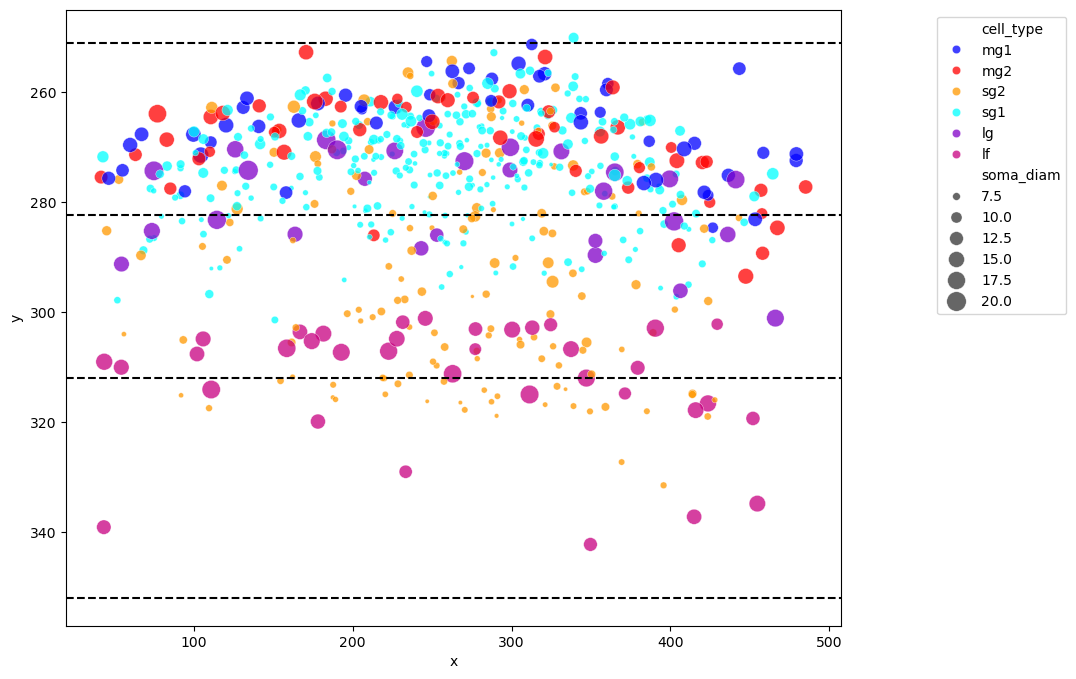

In [109]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_soma[df_soma['cell_type'].isin(['sg1','sg2','mg1','mg2','lg','lf'])],x='x',y='y',hue='cell_type',palette=syn_colors,
                size='soma_diam',sizes=(5, 200),alpha = 0.75)
for y_ in [22000*16, 19500*16, 17650*16, 15700*16]:
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
# ax.set_ylim(15000*16,22500*16)
ax.invert_yaxis()

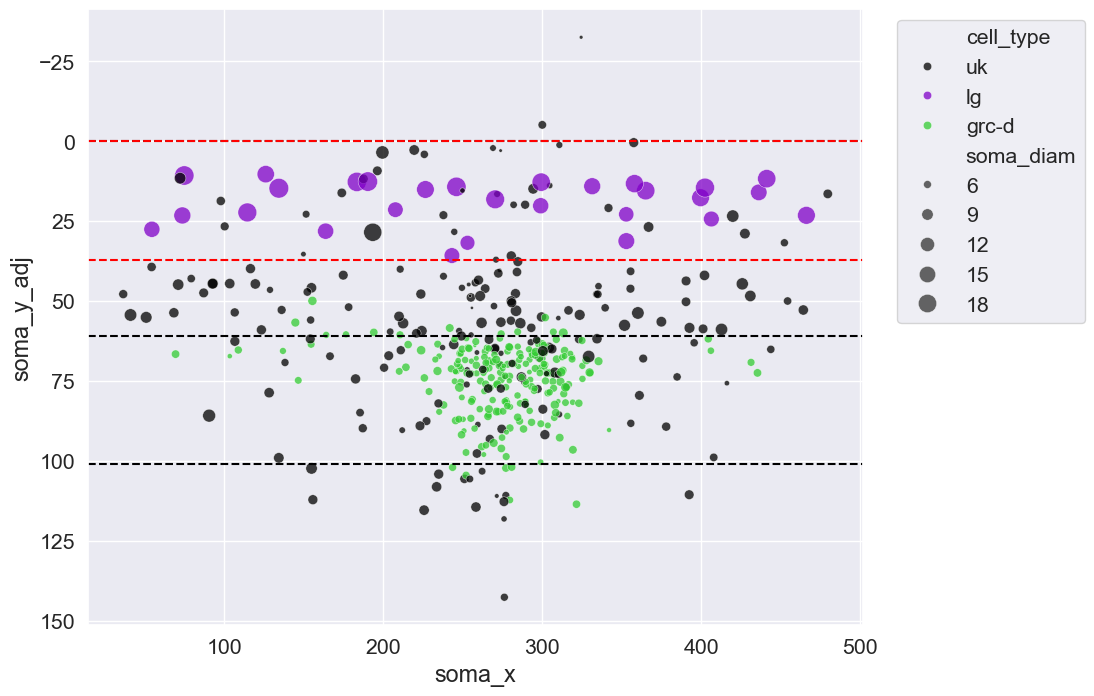

In [159]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_soma[df_soma['cell_type'].isin(['uk','grc-d','lg'])],x='soma_x',y='soma_y_adj',hue='cell_type',palette=syn_colors,size='soma_diam',sizes=(5, 200),alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
# ax.set_ylim(15000*16,22500*16)
ax.invert_yaxis()

In [160]:
(19500-15700)*16

60800

In [182]:
mask = (df_soma['cell_type'].isin(['uk'])) & (df_soma['soma_y_adj']>61) & (100>df_soma['soma_y_adj'])#& (37>df_soma['soma_y_adj']) #

<Axes: xlabel='soma_diam', ylabel='Count'>

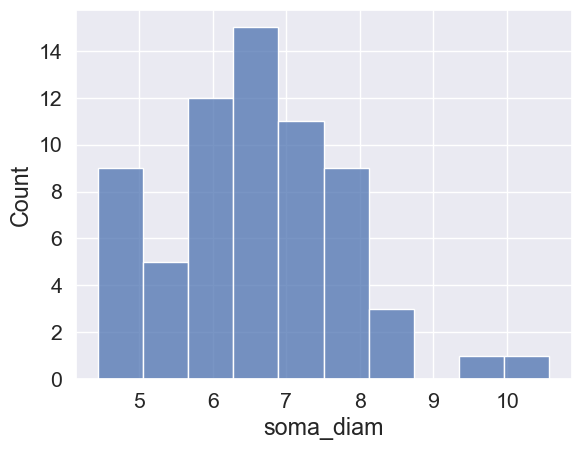

In [183]:
sns.histplot(data=df_soma[mask],x='soma_diam')

In [184]:
df_soma[mask]['id'].values#.sort_values('soma_diam',ascending=False).head(50)#

array([134634255, 137988771, 138130976, 139183144, 142386425, 142571993,
       142651117, 223866888, 223866966, 223912857, 223941461, 224143785,
       224980791, 225028168, 225071474, 226079662, 226247320, 227206860,
       228630093, 230425855, 309678846, 309712320, 309741117, 309802465,
       310513798, 310651611, 310871239, 311987323, 312029654, 312988765,
       313146074, 313562584, 313919138, 314196422, 314212054, 314335736,
       315437044, 391099022, 395542709, 395692303, 396604606, 396838378,
       397705437, 397997102, 399251283, 400522185, 481551715, 482341966,
       482479609, 483779331, 484972148, 484987963, 485018029, 487463682,
        50956829,  50999287,  51991063,  52177863,  52241475,  52320040,
        53215014,  53290934,  53338888,  54435181,  56569306, 567102390,
       571047348,  57373896,  59297712, 654448841, 655220273, 657791522,
       657977227])

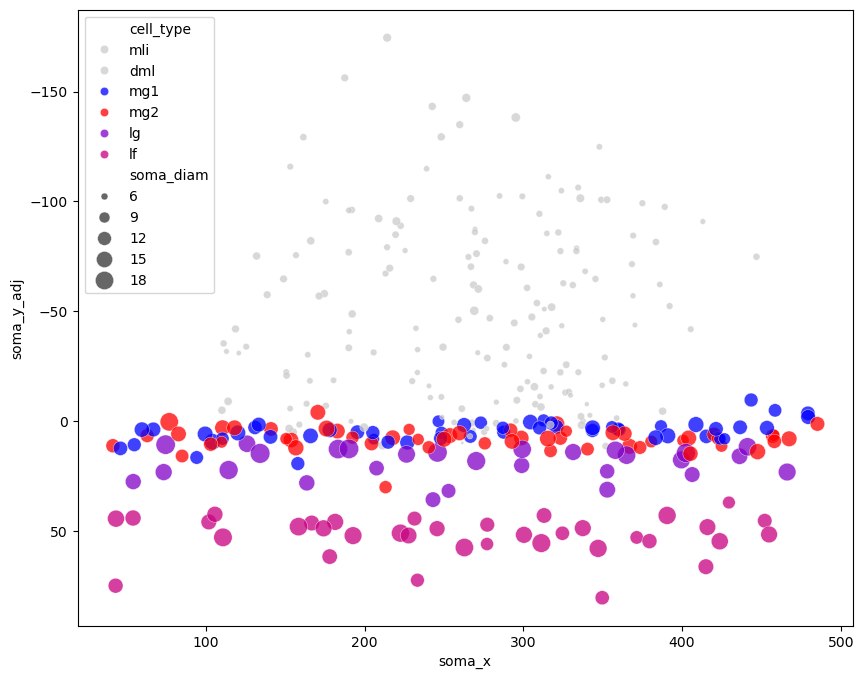

In [538]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_soma[df_soma['cell_type'].isin(['mg1','mg2','lg','lf','mli','dml'])],x='soma_x',y='soma_y_adj',hue='cell_type',palette=syn_colors,size='soma_diam',sizes=(5, 200),alpha = 0.75)
ax.invert_yaxis()

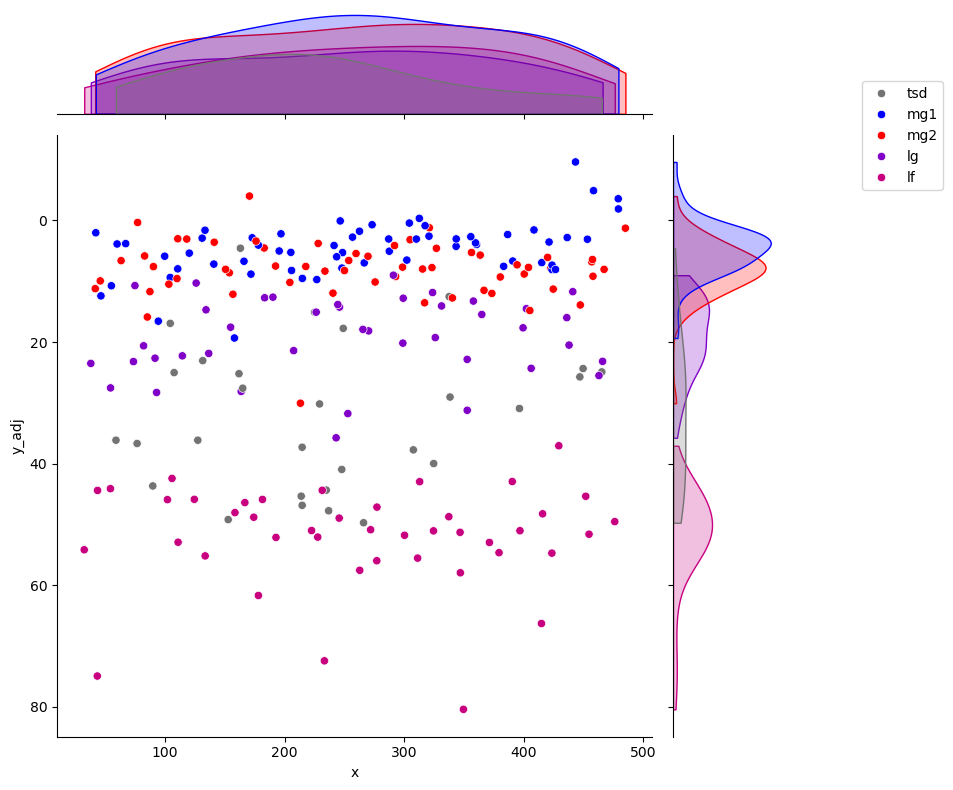

In [126]:
# hfig,ax = plt.subplots(1,figsize=(10,8))
g = sns.jointplot(data=df_soma[df_soma['cell_type'].isin(['mg1','mg2','lg','lf','tsd'])],
              x='x',y='y_adj',hue='cell_type',palette=syn_colors,height=8,marginal_kws = {'cut':0}) #,'grc-d','grc-s','sg1','sg2',
# ax.invert_yaxis()
g.ax_joint.legend(bbox_to_anchor=(1.5, 1.1))
g.ax_joint.invert_yaxis()

### export soma locations to xyz file for blender

In [509]:
soma_pts[0][0]

245690.0

In [16]:
ctype = ['mg2','mg1','lg','lf']

for c_ in ctype:
    soma_pts = df_soma[(df_soma['cell_type'].isin([c_]))][['x','y','z']].values * 1000
    scale_factor = 100000
    
    yaxis_replace_scale = 32768*16/scale_factor
    zaxis_replace_scale = 3500*30/scale_factor
    refpt = [0,0,0]
    
    vertices = [[(v[0]-refpt[0])/scale_factor,
         (v[1]-refpt[1])/scale_factor,
         (v[2]-refpt[2])/scale_factor] for v in soma_pts]
    vertices = [[v[0],yaxis_replace_scale-v[1],-v[2]] for v in vertices] #in this case, the z needed to be mirrored (not sure why did not need to do for cells to blender)
    
    fullpath = f'/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Krista/blender/soma_locations/{c_}_soma.xyz'
    with open(fullpath, 'w') as file:
        for v in vertices:
    
           # file.write(f'{s[0]},{s[1]},{s[2]}\n')
            file.write("{}\t {}\t {}\n".format(v[0],v[2],v[1]))



In [ ]:
# fullpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Krista/blender/mg2_soma.xyz')
with open(fullpath, 'r') as f:
    for line in f:
        values = line.split()
        # print(values)

## distribution soma diam

(5.0, 20.0)

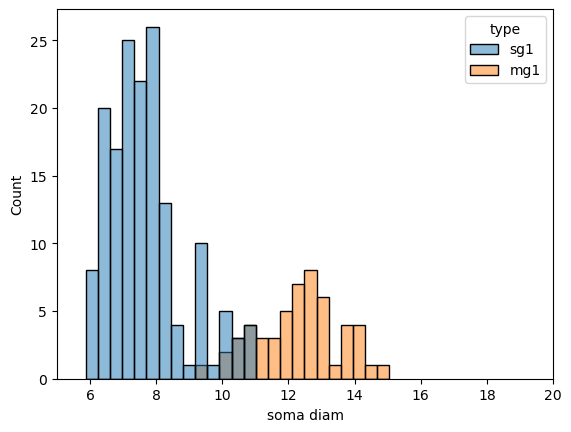

In [482]:

# df['binned'] = pd.cut(df['soma diam'], bins=np.arange(0,4000,200)).values
ax = sns.histplot(data = df[df['type'].isin(['sg1','mg1'])],x='soma diam',bins = 25,hue='type')#,hue='type') ['mg1','mg2','sg1','sg2','sgx1','sgx2']
plt.xlim(5,20)

(5.0, 20.0)

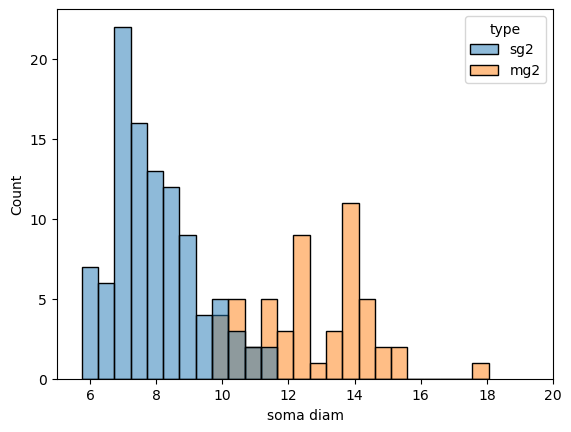

In [461]:
# df['binned'] = pd.cut(df['soma diam'], bins=np.arange(0,4000,200)).values
ax = sns.histplot(data = df[df['type'].isin(['sg2','mg2'])],x='soma diam',bins = 25,hue='type')#,hue='type') ['mg1','mg2','sg1','sg2','sgx1','sgx2']
plt.xlim(5,20)

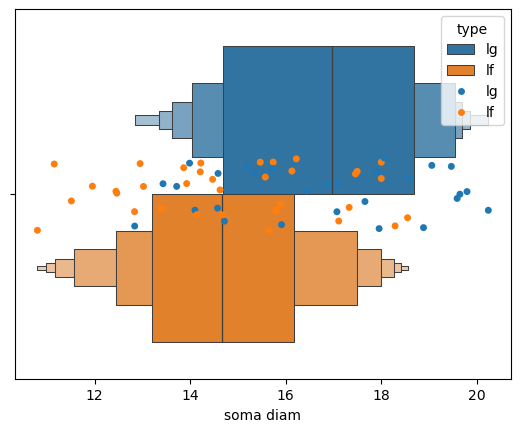

In [402]:
# df['binned'] = pd.cut(df['soma diam'], bins=np.arange(0,4000,200)).values
# ax = sns.histplot(data = df[df['type'].isin(['lg','lf'])],x='soma diam',bins = 10,hue='type')#,hue='type') ['mg1','mg2','sg1','sg2','sgx1','sgx2']
# plt.xlim(5,20)
ax = sns.boxenplot(data = df[df['type'].isin(['lg','lf'])],x='soma diam',hue='type',k_depth ='full')#,hue='type') ['mg1','mg2','sg1','sg2','sgx1','sgx2']
ax = sns.stripplot(data = df[df['type'].isin(['lg','lf'])],x='soma diam',hue='type')#,palette='dark:black')#,k_depth ='full')#,hue='type') ['mg1','mg2','sg1','sg2','sgx1','sgx2']


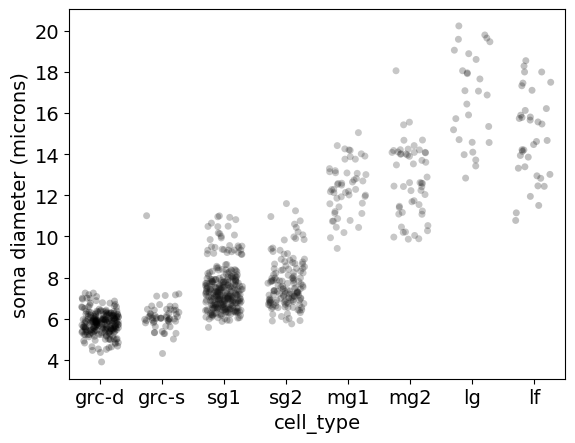

In [545]:

hfig,ax = plt.subplots(1)
# sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','lg','lf'])],x='soma diam',bw_adjust=0.25,cut=0,hue='type',ax=ax) #,'sg1','sg2','sgx1','sgx2'
# sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','lg','lf'])],x='soma diam',bw_adjust=0.25,cut=0,color='black',ax=ax) #,'sg1','sg2','sgx1','sgx2'

sns.stripplot(data = df_soma[df_soma['cell_type'].isin(['grc-d','grc-s','sg1','sg2','mg1','mg2','lg','lf'])],x = 'cell_type',hue='cell_type',y='soma_diam',alpha = 0.25,legend=False,palette='dark:black',order=['grc-d','grc-s','sg1','sg2','mg1','mg2','lg','lf'],jitter=0.3)#,bw_adjust=0.25,cut=0,hue='type',ax=ax) 

ax.set_ylabel('soma diameter (microns)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)


<Axes: xlabel='type', ylabel='soma diam'>

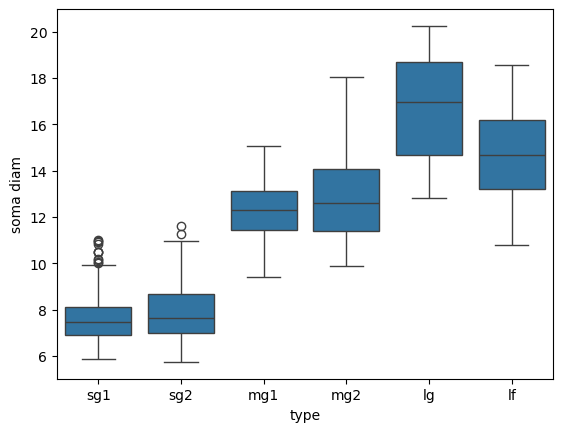

In [463]:
types_include = ['sg1','sg2','mg1','mg2','lg','lf'] #'grc-d','grc-s','sg1','sg2',
sns.boxplot(data = df[df['type'].isin(types_include)], y = 'soma diam', x = 'type',order = types_include)

In [32]:
df.groupby('type')['soma diam'].describe()

count       mean       std      min        25%       50%        75%  \
type                                                                         
UK       0.0        NaN       NaN      NaN        NaN       NaN        NaN   
aff      0.0        NaN       NaN      NaN        NaN       NaN        NaN   
dml     32.0   6.049984  0.603641   5.1600   5.677625   5.87475   6.343375   
fov      0.0        NaN       NaN      NaN        NaN       NaN        NaN   
glia     5.0   6.822300  3.150928   3.7330   5.740000   6.04850   6.451500   
grc-d   44.0   5.980886  0.595482   3.8960   5.621250   5.96700   6.331625   
grc-s   20.0   6.391450  1.134542   5.2760   6.016500   6.10500   6.429500   
lf      33.0  15.003606  2.127972  10.7975  13.391000  14.67150  17.094500   
lg      27.0  16.720630  2.274393  12.8350  14.645000  16.88000  18.748500   
mg1     54.0  12.198065  1.398795   8.0450  11.147875  12.24075  13.098875   
mg2     49.0  12.759408  1.811253   9.8605  11.413500  12.59550  14.093000   
mli    102.0   5.984319  0.520526   4.4330   5.601375   5.95125   6.296625   
pe       0.0        NaN       NaN      NaN        NaN       NaN        NaN   
pf       0.0        NaN       NaN      NaN        NaN       NaN        NaN   
sg1    148.0   7.662527  1.138838   6.0025   6.889375   7.46650   8.147375   
sg2     89.0   7.956994  1.315587   5.7455   6.991500   7.72500   8.729000   
sgx1    25.0   6.508200  0.611328   5.5100   6.148000   6.40550   6.801000   
sgx2    14.0   6.145536  0.735066   5.0125   5.727750   5.83425   6.476375   
tsd     14.0   9.953929  1.246642   7.8165   9.360875   9.77900  10.758250   
uk      97.0   7.512103  1.526092   5.0390   6.746000   7.39200   7.929000   

           max  
type            
UK         NaN  
aff        NaN  
dml     7.4780  
fov        NaN  
glia   12.1385  
grc-d   7.2460  
grc-s  11.0115  
lf     18.5535  
lg     20.2435  
mg1    15.0530  
mg2    18.0595  
mli     7.4490  
pe         NaN  
pf         NaN  
sg1    10.9970  
sg2    11.6010  
sgx1    7.7900  
sgx2    7.7605  
tsd    12.7240  
uk     17.6950

## Load into df_edges

In [9]:

for i,r in df_edges.iterrows():
    try:
        df_edges.loc[i,'pre_diam']=soma_diam[df_edges.loc[i,'pre']]
        df_edges.loc[i,'post_diam']=soma_diam[df_edges.loc[i,'post']]
    except:
        continue
df_edges.loc[:,'diam_diff'] = (df_edges['post_diam']-df_edges['pre_diam'])/df_edges['pre_diam']


# Cell types dict from df_edges

In [21]:
cell_type = {}

for i,r in df_edges.iterrows():
    cell_type[r['pre']]=r['pre_type'].lower()
    cell_type[r['post']]=r['post_type'].lower()
    


In [22]:
df_type = pd.DataFrame(cell_type.items(),columns = ['id','type'])

In [192]:
n = sum(df_type['type'].isin(['lf','lg']))
n1 = sum(df_type['type'].isin(['lg']))
n2 = sum(df_type['type'].isin(['lf']))
print(f'{n} total ouput in network; {n1} lg, {n2} lf')

84 total ouput in network; 41 lg, 43 lf


In [193]:
n = sum(df_type['type'].isin(['mg1','mg2']))
n1 = sum(df_type['type'].isin(['mg1']))
n2 = sum(df_type['type'].isin(['mg2']))
print(f'{n} total mg in network; {n1} mg1, {n2} mg2')

117 total mg in network; 60 mg1, 57 mg2


In [195]:
n = sum(df_type['type'].isin(['sg1','sg2']))
n1 = sum(df_type['type'].isin(['sg1']))
n2 = sum(df_type['type'].isin(['sg2']))
print(f'{n} total sg in network; {n1} sg1, {n2} sg2')

363 total sg in network; 224 sg1, 139 sg2


In [171]:
n = df_edges[df_edges['pre_type'].isin(['mg1','mg2'])]['pre'].nunique()
print(f'{n} have synapses labeled')

101 have synapses labeled


In [172]:
sum(df_type['type'].isin(['pf']))

37

# synapses locations in df_syn

## absolute

In [29]:
df_syn = pd.read_csv(dirpath / 'graphs/df_presyn.csv')
syn = 'post-synaptic'

In [30]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088'
}

In [31]:
for v in ['x','y','z']:
    df_syn[v] = df_syn[v]/1000
    

In [32]:
df_syn['y'] = df_syn['y']*-1

In [34]:
df_syn[df_syn['pre_type'].isin(['mg2'])]['pre'].unique()

array([126649726, 214581797, 386392158, 472361842])

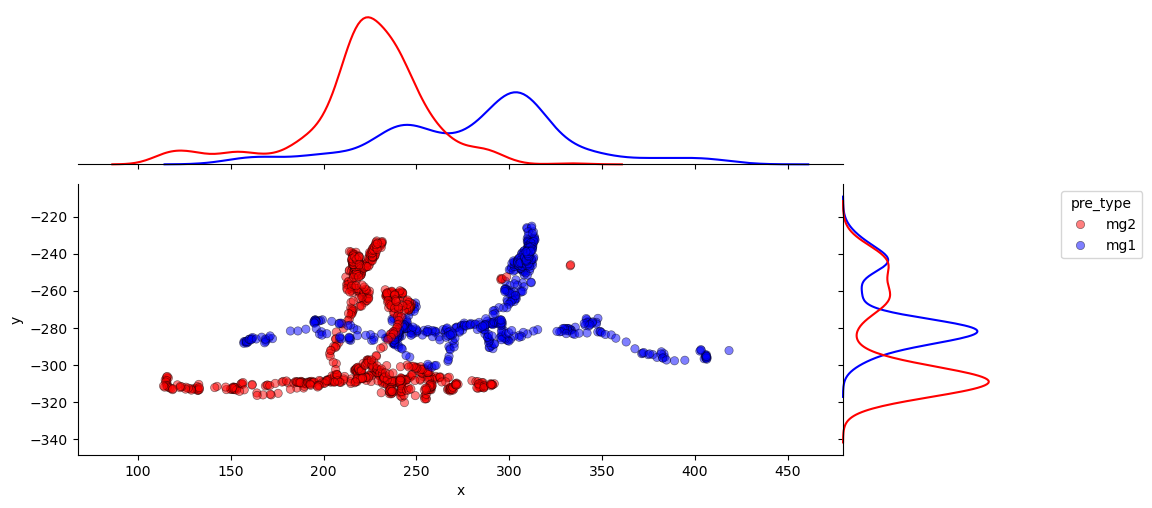

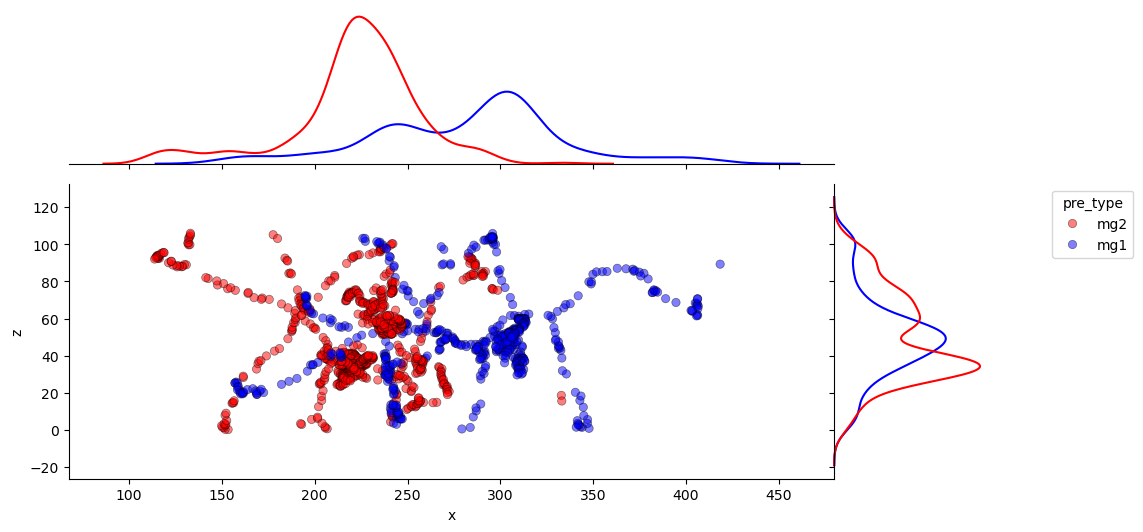

In [35]:

g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y", hue="pre_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="z", hue="pre_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

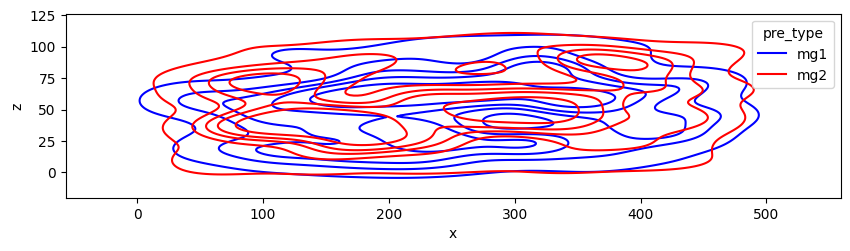

In [49]:
hfig,ax = plt.subplots(1,figsize=(10,10))

g = sns.kdeplot(ax = ax,data = df_syn[df_syn['pre_type'].isin(['mg2','mg1',])],x='x',y='z',hue='pre_type',
                common_norm=True,palette=syn_colors,levels=6)#,thresh=0.15)#,fill=True,alpha = 0.25)

ax = plt.gca()
# ax.set_xlim(-100,100)
ax.set_aspect('equal')

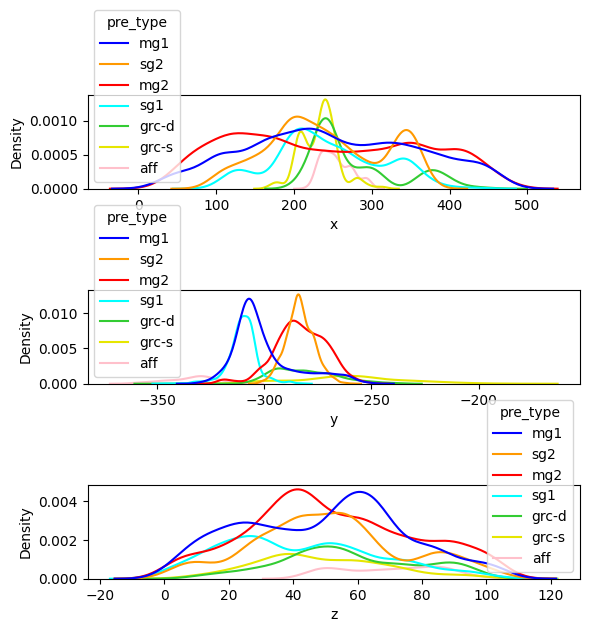

In [61]:
hfig,ax = plt.subplots(3,figsize=(6,6))
sns.kdeplot(ax=ax[0],data = df_syn[df_syn['pre_type'].isin(['aff','sg2','mg2','sg1','mg1','grc-d','grc-s'])],x='x',hue='pre_type',common_norm=True,clip_on=0,palette=syn_colors)
sns.kdeplot(ax=ax[1],data = df_syn[df_syn['pre_type'].isin(['aff','sg2','mg2','sg1','mg1','grc-d','grc-s'])],x='y',hue='pre_type',common_norm=True,clip_on=0,palette=syn_colors)
sns.kdeplot(ax=ax[2],data = df_syn[df_syn['pre_type'].isin(['aff','sg2','mg2','sg1','mg1','grc-d','grc-s'])],x='z',hue='pre_type',common_norm=True,clip_on=0,palette=syn_colors)
plt.tight_layout()

## relative to cell type soma 

### df_syn pre or post

In [21]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
syn = 'post-synaptic'

In [22]:
df_syn.loc[df_syn['post_type'].isin(['dml']),'post_type']='mli'

df_syn.loc[df_syn['pre_type'].isin(['dml']),'pre_type']='mli'

### plot

In [23]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373' 
}

In [ ]:
df_syn

In [25]:
df_loc = pd.DataFrame(soma_loc.items(), columns=['cell', 'soma loc']).set_index('cell')
post_types_subset = ['lf','lg']

for c in df_loc.index:
    df_loc.loc[c,'type'] = cell_types[c]

# df_to_plot = df_loc[(df_loc.index.isin(df_progress[df_progress['completed']>0.9]['id'].values))&df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()
df_to_plot = df_loc[df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()

# Initialize an empty DataFrame
df_syn_locs = pd.DataFrame(columns=['x', 'y', 'z', 'cell_type'])

# Loop through cell types and extend the DataFrame
for i,r in df_to_plot.iterrows():
    # print(i,r)
    
    x,y,z = r['soma loc']
    cell = df_syn[(df_syn['pre'].isin([int(i)])) & (df_syn['post_type'].isin(post_types_subset))]
    # cell = ecrest(settings_dict,filepath = nodefiles[i],launch_viewer=False)
    positions = [(s[0]/1000-x,s[1]/1000-y,s[2]/1000-z) for s in list(cell[['x','y','z']].to_records(index=False))]#cell.cell_data['end_points']['post-synaptic']]
   
    # break
    cell_df = pd.DataFrame(positions, columns=['x', 'y', 'z'])  # Create DataFrame for the current cell type
    cell_df['cell_type'] = r['type']  # Add cell type column
    df_syn_locs = pd.concat([df_syn_locs, cell_df], ignore_index=True)  # Concatenate the current cell DataFrame to the main DataFrame

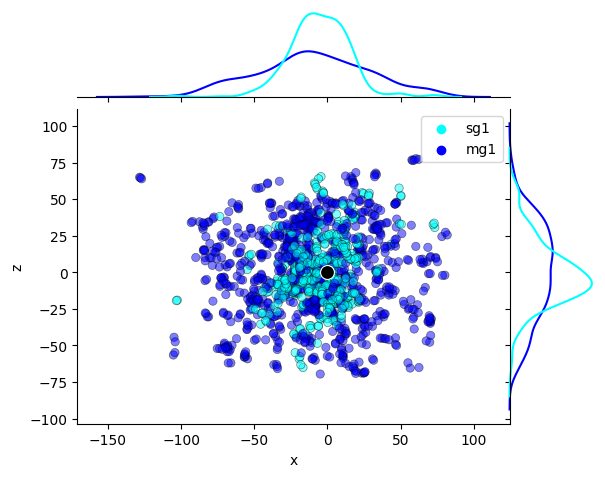

In [26]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','mg1'])], 
                  x="x", y="z", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), space=0)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);

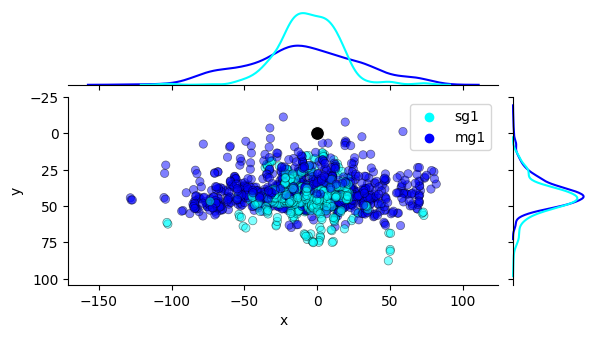

In [27]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','mg1'])], 
                  x="x", y="y", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), ratio=5)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

g.ax_joint.invert_yaxis()

g = sns_joint_equal_axes(g)

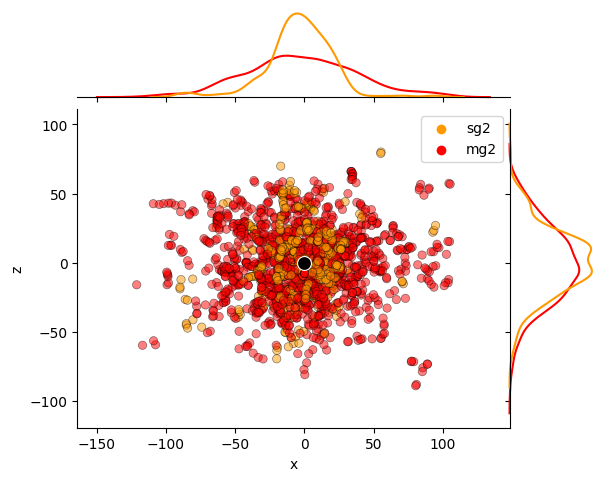

In [28]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2','mg2'])], 
                  x="x", y="z", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), space=0)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);

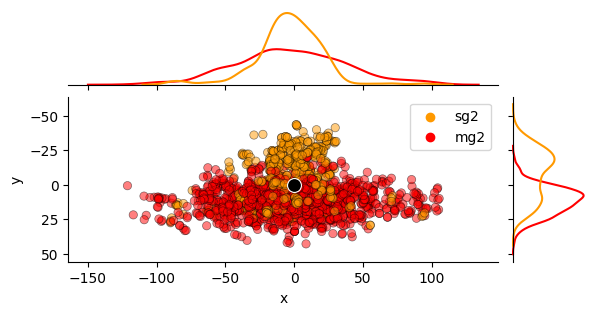

In [29]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2','mg2'])], 
                  x="x", y="y", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), ratio=5)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

g.ax_joint.invert_yaxis()

g = sns_joint_equal_axes(g)

In [ ]:
g.ax_joint.set_aspect('equal')

this needs to be restricted to data from cells within 150 microns of edge in x (and only analyzed in x) to avoid edge effects


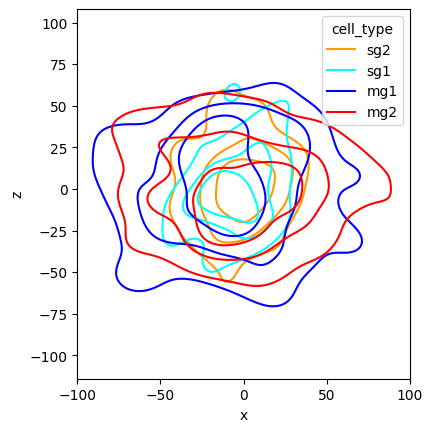

In [31]:
# hfig,ax = plt.subplots(1,figsize=(3,6))
g = sns.kdeplot(data = df_syn_locs,x='x',y='z',hue='cell_type',common_norm=False,palette=syn_colors,levels=4,thresh=0.15)#,fill=True,alpha = 0.25)

ax = plt.gca()
ax.set_xlim(-100,100)
ax.set_aspect('equal')

# hfig,ax = plt.subplots(3,figsize=(6,6))
# sns.kdeplot(ax=ax[0],data = df_syn_locs,x='x',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[1],data = df_syn_locs,x='y',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[2],data = df_syn_locs,x='z',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# plt.tight_layout()

print('this needs to be restricted to data from cells within 150 microns of edge in x (and only analyzed in x) to avoid edge effects')

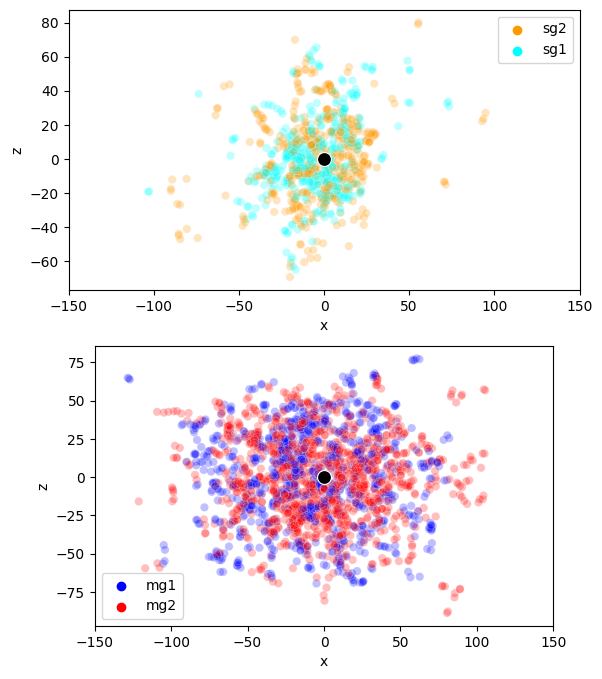

In [32]:
hfig,ax = plt.subplots(2,figsize=(10,8))
sns.scatterplot(ax=ax[0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','sg2'])],
                x = 'x', y='z',alpha = 0.25,hue='cell_type',palette=syn_colors) #,color='black'
sns.scatterplot(ax=ax[0],x=[0],y=[0],color='black',s=100)
sns.scatterplot(ax=ax[1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg1','mg2'])],
                x = 'x', y='z',alpha = 0.25,hue='cell_type',palette=syn_colors) #,color='black'
sns.scatterplot(ax=ax[1],x=[0],y=[0],color='black',s=100)
for a in ax:
    a.set_xlim(-150,150)
    # a.set_ylim(-3000,3000)
    a.set_aspect('equal')

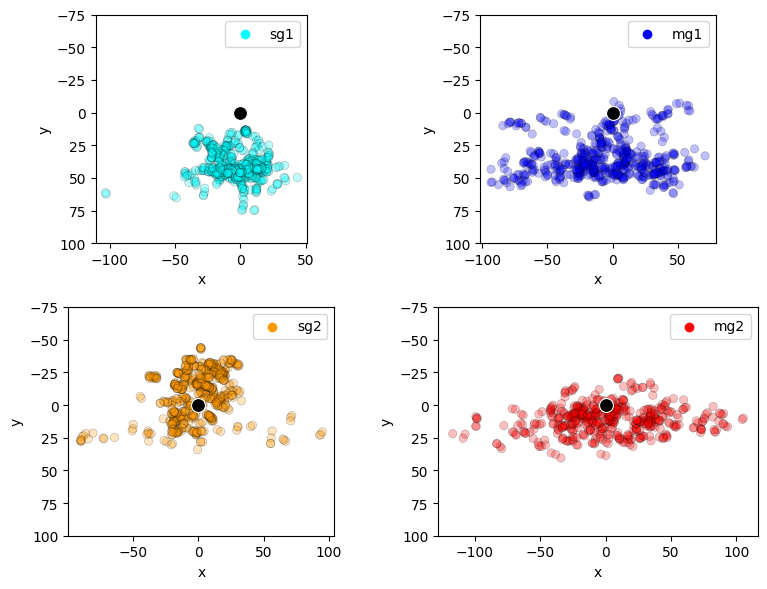

In [1582]:
hfig,ax = plt.subplots(2,2,figsize=(8,6))
sns.scatterplot(ax=ax[0,0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[1,0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[0,1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg1'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[1,1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg2'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
for a in ax:
    for a2 in a:
        sns.scatterplot(ax=a2,x=[0],y=[0],color='black',s=100)

for a in ax:
    for a2 in a:
        # a2.set_xlim(-200,200)
        a2.set_ylim(-75,100)
        a2.set_aspect('equal')
        a2.invert_yaxis()

plt.tight_layout()


# Completeness of synapses



In [77]:
cell_type

'pre-synaptic'

In [391]:
all_types = set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique()) #- set(['glia'])
c_type_check = all_types #['mg1','mg2','sg1','sg2','grc']

df_progress = pd.DataFrame(columns = ['id','type','n_syn','done','todo','completed']) #'soma-diam',
for c in df_edges['pre'].unique():
    
    if (df_edges[df_edges['pre'] == c]['pre_type'].unique()[0] in c_type_check):

        c_df = df_edges[df_edges['pre'].isin([c])]
        n_syn_done = c_df['weight'].sum()

        cell = ecrest(settings_dict,filepath = nodefiles[str(c)],launch_viewer=False)
        
        if len(cell.cell_data['end_points'][syn])>0:
            # try:
            cell_dict = {
                'id': cell.cell_data['metadata']['main_seg']['base'],
                'type': cell_type[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': len(cell.cell_data['end_points'][syn]),
                'done': n_syn_done, #len(c_df),
                'todo': len(cell.cell_data['end_points'][syn]) - n_syn_done, #len(c_df),
                'completed': n_syn_done / (len(cell.cell_data['end_points'][syn]))
                }
            # except:
            #     print(f'error on {c}')
            #     continue
        
        if len(cell.cell_data['end_points'][syn])==0:
            cell_dict = {
                'id': cell.cell_data['metadata']['main_seg']['base'],
                'type': cell_types[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': np.NaN,
                'done': n_syn_done, #len(c_df),
                'todo': np.NaN, #len(c_df),
                'completed': np.NaN
                }
            # print(f'error on {c}')
            # continue

        df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_41492/3862874507.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])


In [24]:
df_progress[df_progress['type'].isin(['pf'])][['n_syn']].sort_values('n_syn').sum()

n_syn    0.0
dtype: float64

In [200]:
len(df_progress[df_progress['type'].isin(['pf'])][['id','n_syn']].sort_values('n_syn'))

35

<AxesSubplot:xlabel='n_syn', ylabel='Count'>

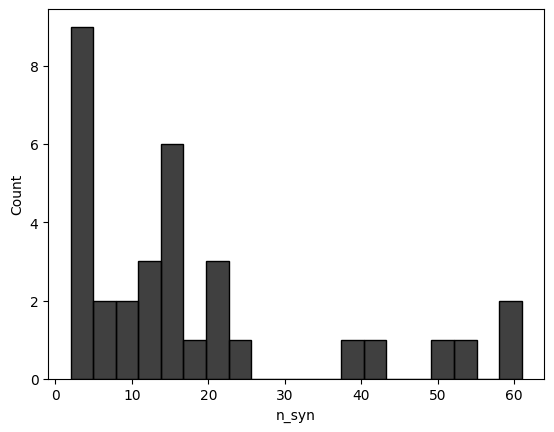

In [201]:
sns.histplot(df_progress[(df_progress['type'].isin(['pf']))&(df_progress['n_syn']>1)]['n_syn'],color='black',bins=20)#['id'].values

In [399]:
df_progress[(df_progress['type'].isin(['sg1','sg2']))].sort_values('todo').head(100) #  ['id'].values# & (df_progress['todo']<12)]['id'].values #  #& (df_progress['todo']>0)

id type n_syn done todo  completed
0  218095913  sg2   134  119   15   0.888060
0  385434515  sg2   135  102   33   0.755556
0  128832297  sg1   188  125   63   0.664894
0  306461085  sg2   228  153   75   0.671053
0  387554847  sg1   165   81   84   0.490909
0  647514445  sg2   165   80   85   0.484848
0  387493257  sg1   118   29   89   0.245763
0  387305421  sg1   170   21  149   0.123529

In [62]:
df_soma[df_soma['id'].isin(df_progress[(df_progress['type'].isin(['sg1','sg2']))]['id'].values)]

Empty DataFrame
Columns: [id, soma_diam, cell_type, x, y, z]
Index: []

In [41]:
labeled_recent = ['44517560', '128813171','213760634','214411806','215030183','216081986','559551706','642905044','40448913','41670234','300226567','300503092','477300082','642458763','644824766']


df_progress[df_progress['id'].isin(labeled_recent)].sort_values('todo')
    

 # 560744270, kp 
 # 560819551, kp
    # 40665046, kp
 

id type n_syn done todo  completed
0  642905044  mg1    52   52    0   1.000000
0  300503092  mg2    75   75    0   1.000000
0  642458763  mg2    39   39    0   1.000000
0  477300082  mg2    51   51    0   1.000000
0  300226567  sg2    32   32    0   1.000000
0  644824766  mg2    51   50    1   0.980392
0  215030183  mg1    22   21    1   0.954545
0   41670234  sg2    31   29    2   0.935484
0  213760634  mg1    40   37    3   0.925000
0   40448913  mg2    49   45    4   0.918367
0  128813171  mg1    34   30    4   0.882353
0  214411806  mg1    80   69   11   0.862500
0  216081986  sg1    54   43   11   0.796296
0   44517560  sg1    30   15   15   0.500000
0  559551706  sg1    91   64   27   0.703297

In [16]:
df_progress[df_progress['completed']>0.9][['id','type','completed']].groupby('type').describe()

completed                                                              \
          count      mean       std       min       25%       50%       75%   
type                                                                          
dml         3.0  0.975370  0.031409  0.940000  0.963056  0.986111  0.993056   
grc-d      12.0  0.998428  0.005447  0.981132  1.000000  1.000000  1.000000   
grc-s      10.0  0.995663  0.010413  0.967742  1.000000  1.000000  1.000000   
mg1        51.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000   
mg2        50.0  0.999770  0.001626  0.988506  1.000000  1.000000  1.000000   
mli         2.0  0.996212  0.005357  0.992424  0.994318  0.996212  0.998106   
pe          4.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000   
pf         35.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000   
sg1        19.0  0.993493  0.022294  0.903226  1.000000  1.000000  1.000000   
sg2        24.0  0.971696  0.035563  0.902439  0.942204  0.997191  1.000000   
sgx1        1.0  1.000000       NaN  1.000000  1.000000  1.000000  1.000000   
sgx2        1.0  1.000000       NaN  1.000000  1.000000  1.000000  1.000000   
tsd         1.0  1.000000       NaN  1.000000  1.000000  1.000000  1.000000   

            
       max  
type        
dml    1.0  
grc-d  1.0  
grc-s  1.0  
mg1    1.0  
mg2    1.0  
mli    1.0  
pe     1.0  
pf     1.0  
sg1    1.0  
sg2    1.0  
sgx1   1.0  
sgx2   1.0  
tsd    1.0

# Filtered df_edges

In [595]:
# Filter by pre and/or post cell type

network_types = ['mg1','mg2','sg1','sg2','lg','lf','grc-d','grc-s']#,'lg','lf','glia']#(set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique())) #- set(['glia'])

# df_edges = df_edges[(df_edges['pre_type'].isin(network_types - set(['sgx1','sgx2'])))&(df_edges['post_type'].isin(network_types))]# - set(['lg','lf'])

# df_edges = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))]# - set(['lg','lf'])

df_edges = df_edges[(df_edges['pre_type'].isin(network_types)) & (df_edges['post_type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2','aff','grc-d','grc-s']))]

In [90]:
canonical_sgs = [386455093, 387554847, 301693439, 387493257, 387677355, 300596446,
       302654853, 302668963, 215712894, 386565412,389891998, 220336851, 308471538, 309743149, 392055938, 476801247,
       393433572, 477962738, 473491444, 394423863] # from min 10 kdist kmeans on sg cluster with ['soma_diam','bdstd_x','axstd_x','axstd_z','bdstd_z','soma_x','soma_z']
        # see where others done are in that distrubution: 218095913, 385434515
mask = (df_edges['pre_type'].isin(['sg1','sg2'])) & ~(df_edges['pre'].isin(canonical_sgs))
df_edges.drop(df_edges[mask].index, inplace=True)

In [359]:
df_edges = df_edges[df_edges['pre'].isin([int(id_) for id_ in df_progress[(df_progress['type'].isin(['mli'])) & (df_progress['n_syn']>1)]['id'].values])]

In [19]:
# Filter by completeness of synaptic reconstructions
df_edges_completed = df_edges[df_edges['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.9]['id'].values])]

In [20]:
# add afferent back in for postsynaptic even though not complete
df_edges = pd.concat([df_edges_completed,df_edges[df_edges['pre_type'].isin(['aff'])]])
   

In [204]:
# if syn=='post-synaptic':
#     df_syn_completed = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.9]['id'].values])]
#     df_syn = pd.concat([df_syn_completed,df_syn[df_syn['pre_type'].isin(['aff'])]])
    
    
# if syn=='pre-synaptic':
#     df_syn = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.3]['id'].values])]

In [400]:
df_progress[(df_progress['type'].isin(['sg1','sg2']))].sort_values('todo').head(100) #  ['id'].values# & (df_progress['todo']<12)]['id'].values #  #& (df_progress['todo']>0)

id type n_syn done todo  completed
0  218095913  sg2   134  119   15   0.888060
0  385434515  sg2   135  102   33   0.755556
0  128832297  sg1   188  125   63   0.664894
0  306461085  sg2   228  153   75   0.671053
0  387554847  sg1   165   81   84   0.490909
0  647514445  sg2   165   80   85   0.484848
0  387493257  sg1   118   29   89   0.245763
0  387305421  sg1   170   21  149   0.123529

## cells to target for connection

In [146]:
# syn_to_lg = df_edges[(df_edges['post'].isin([214503199]))&df_edges['pre_type'].isin(['mg2'])]['pre'].values
syn_to_lg = df_edges[(df_edges['post_type'].isin(['lg']))&df_edges['pre_type'].isin(['mg2'])]['pre'].values
mask = (df_edges['post'].isin(syn_to_lg)) & (df_edges['pre_type'].isin(['mg1']))
df_edges[mask].groupby('post')['pre'].nunique()

post
40448913      2
40665046      1
41825714      2
128536704     4
129030308     4
129512755     4
129619070     6
213605530    12
214581797     9
216129202     5
216177846     2
216192012     1
217396339     2
218575005     5
299249397     3
299404889    11
300316308     3
300689181     3
301308616     4
301339154     3
303212610     6
303287910     3
303877666     1
386117124     3
386300356     1
386392158     1
386426114     1
387091598     2
387338914    11
387850816     5
390294014     3
472051969     1
472284925     3
472517114     3
473631846     7
474839189     2
477300082     4
558300217     5
644823522     2
644824766     1
646634295     1
647809492     1
Name: pre, dtype: int64

In [147]:
# syn_to_lg = df_edges[(df_edges['post'].isin([393464000]))&df_edges['pre_type'].isin(['mg1'])]['pre'].values
syn_to_lg = df_edges[(df_edges['post_type'].isin(['lf']))&df_edges['pre_type'].isin(['mg1'])]['pre'].values
mask = (df_edges['post'].isin(syn_to_lg)) & (df_edges['pre_type'].isin(['mg2']))
df_edges[mask].groupby('post')['pre'].nunique()

post
42632020      5
43622486      2
44548558      3
126618353     5
127870654     6
128737253     8
131585534     3
213590737     3
213669553     9
213760634     2
214411806     8
214550811     2
215030183     4
215480645     5
299392199     1
299439953     6
299496636    11
299530386     4
300131090     1
300210608     9
300459385     2
302143252     5
303244291     1
386114963     7
386224676     8
386612701     1
386643184     5
387909811    10
389085521     4
472114046     4
472175645     2
472282894     2
473723476     4
474111084     6
474236060     5
474373577     2
476167179     5
558360429     7
560744270     6
560819551     7
642905044     1
643848637     3
644005141     2
644143297     2
Name: pre, dtype: int64

In [144]:

df_edges[(df_edges['post'].isin([299496636])) &df_edges['pre_type'].isin(['mg2'])]['pre'].values

array([386392158, 472361842, 472284925, 472517114,  40665046, 558300217,
       646634295, 472051969, 129030308, 300689181, 300503092])

# Connectivity relative to other cells


### soma loc df

In [503]:
dirpath = Path(settings_dict['save_dir'])
nodefiles = get_cell_filepaths(dirpath)

### distance for connected versus unconnected

In [219]:
df_soma.head()


id  soma_diam cell_type  soma_x  soma_y  soma_z       y_adj
0  109461049        NaN       fov     NaN     NaN     NaN         NaN
1  109502641        5.8       mli  334.54  145.68   15.26 -106.323605
2  110418632        NaN        uk     NaN     NaN     NaN         NaN
3  110611085        NaN       fov     NaN     NaN     NaN         NaN
4  110620163        NaN       fov     NaN     NaN     NaN         NaN

In [289]:
df_sub = df_syn[(df_syn['pre_type'].isin(['mg1','mg2'])) & (df_syn['post_type'].isin(['mg1','mg2']))] #'lg','lf'

distances_connected = []
for pre in df_sub['pre'].unique():
    source_ids = ('id',[pre])
    target_ids = ('id',df_sub[(df_sub['pre'].isin([pre]))]['post'].unique())
    d = pairwise_distances(df_soma, target_ids = target_ids, source_ids = source_ids)
    distances_connected.extend(d)
    
distances_unconnected = []
for pre in df_sub['pre'].unique():
    source_ids = ('id',[pre])
    
    # post ids not connected to this pre
    post_not_targets = list(set(df_sub['post'].unique()) - set(df_sub[(df_sub['pre'].isin([pre]))]['post'].unique()))
    
    target_ids = ('id',post_not_targets)
    d = pairwise_distances(df_soma, target_ids = target_ids, source_ids = source_ids)
    distances_unconnected.extend(d) 
distances_unconnected = [d for d in distances_unconnected if d>0]

data = {'connected' : distances_connected, 'unconnected' : distances_unconnected}
data = pd.DataFrame.from_dict(data, orient='index').transpose()

data = data.melt(var_name = 'pairwise', value_name='distance')
data['distance']=data['distance']#/1000

# plt.figure(figsize=(3,5))

# # sns.stripplot(data = data, y = 'distance',x = 'pairwise',jitter = 0.3,alpha = 0.3,color = 'black')#datadistances_connected)
# sns.boxplot(data = data, y = 'distance',x = 'pairwise',color='gray',zorder=3)
# # sns.scatterplot(distances_unconnected)
# plt.ylim(-1,500)

# plt.figure(figsize=(6,2))
# sns.kdeplot(data = data, x = 'distance',hue = 'pairwise',common_norm=True,cut=0)

# data.groupby(['pairwise']).describe()

# Define the number of bins and bin width
num_bins = 100
bin_width = (data['distance'].max() - data['distance'].min()) / num_bins

# Create bins
bins = np.arange(data['distance'].min(), data['distance'].max() + bin_width, bin_width)

# Bin the distance column
data['distance_bin'] = pd.cut(data['distance'], bins=bins, include_lowest=True)


# Group by distance bins and calculate the probability of connection
prob_connected = data.groupby('distance_bin')['pairwise'].apply(lambda x: (x == 'connected').mean()).reset_index() # for example, np.mean([True,False]) = 0.5 so it accomplishes what the following would: data.groupby('distance_bin')['pairwise'].apply(lambda x: (x == 'connected').sum() / len(x)).reset_index()

prob_connected['distance_mid']=pd.to_numeric(prob_connected['distance_bin'].apply(lambda x: x.mid))

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_41492/917640650.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_connected = data.groupby('distance_bin')['pairwise'].apply(lambda x: (x == 'connected').mean()).reset_index() # for example, np.mean([True,False]) = 0.5 so it accomplishes what the following would: data.groupby('distance_bin')['pairwise'].apply(lambda x: (x == 'connected').sum() / len(x)).reset_index()


In [290]:
prob_connected_mg = prob_connected

In [288]:
prob_connected_output = prob_connected

In [292]:
# Add 'target' column with 'mg' value for prob_connected_mg dataframe
prob_connected_mg['target'] = 'mg'

# Add 'target' column with 'output' value for prob_connected_output dataframe
prob_connected_output['target'] = 'output'

# Append the dataframes together
prob_connected = pd.concat([prob_connected_mg, prob_connected_output], ignore_index=True)


In [269]:
from scipy.optimize import curve_fit

def func(x, a, b):#, c):
    return a*x + b #a * np.exp(-b * x) + c

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[None]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


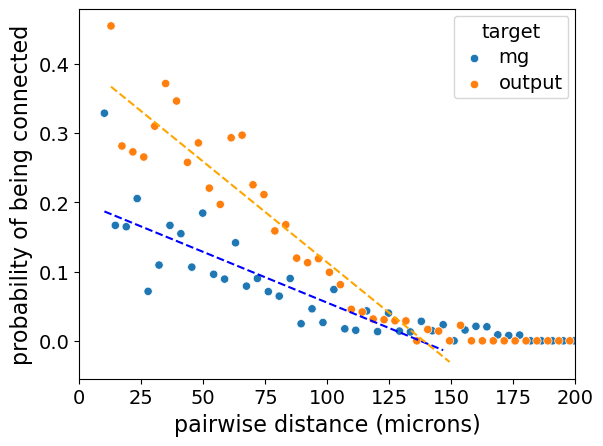

In [316]:
# Plot the relationship
ax = sns.scatterplot(data=prob_connected,x='distance_mid',y='pairwise',hue='target')
ax.set_xlim(0,200)


mask = (prob_connected_mg['distance_mid'] <150)
x = prob_connected_mg[mask]['distance_mid']
y = prob_connected_mg[mask]['pairwise'].values
popt, pcov = curve_fit(func, x, y)
ax.plot(x, func(x, *popt), color = 'blue', linestyle = '--')


mask = (prob_connected_output['distance_mid'] <150)
x = prob_connected_output[mask]['distance_mid']
y = prob_connected_output[mask]['pairwise'].values
popt, pcov = curve_fit(func, x, y)
ax.plot(x, func(x, *popt), color = 'orange', linestyle = '--')

ax.set_xlabel('pairwise distance (microns)', fontsize=16)
ax.set_ylabel('probability of being connected', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.tick_params(axis='both', which='minor', labelsize=8)

plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### connection weight as a function of distance

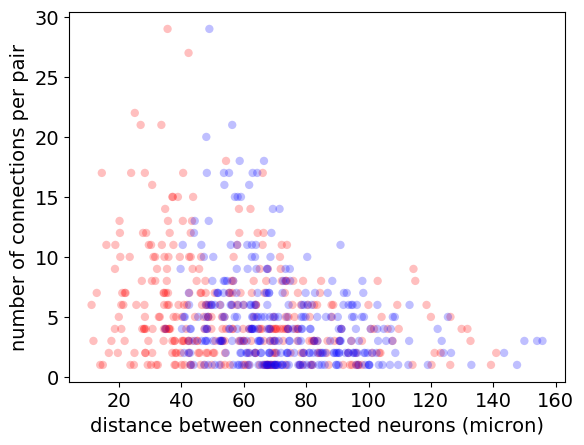

In [280]:
hfig,ax = plt.subplots(1)

df_sub = df_edges[(df_edges['pre_type'].isin(['mg2'])) & (df_edges['post_type'].isin(['lg']))]

d = []
w = []
for i,r in df_sub.iterrows():
    try:
        # print('done')
        d.append(pairwise_distances(df_soma, target_ids = ['id',[r['post']]], dimensions = ['x','y','z'], source_ids = ['id',[r['pre']]]))
        w.append(r['weight'])
    except KeyError as msg:
        print(msg)
        continue
# needs_soma.unique()

ax.scatter(array(d)/1000,w,alpha = 0.25,color='red',edgecolors='none')#color = {'mg1':'blue', 'mg2':'red'})


df_sub = df_edges[(df_edges['pre_type'].isin(['mg1'])) & (df_edges['post_type'].isin(['lf']))]

d = []
w = []
for i,r in df_sub.iterrows():
    try:
        # print('done')
        d.append(pairwise_distances(df_soma, target_ids = ['id',[r['post']]], dimensions = ['x','y','z'], source_ids = ['id',[r['pre']]]))
        w.append(r['weight'])
    except KeyError as msg:
        print(msg)
        continue
# needs_soma.unique()

ax.scatter(array(d)/1000,w,alpha = 0.25,color='blue',edgecolors='none')#color = {'mg1':'blue', 'mg2':'red'})


plt.ylabel('number of connections per pair')
plt.xlabel('distance between connected neurons (micron)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.savefig('/Users/kperks/Downloads/connection-distance-mg-out-scatter.svg') 

### scatter of connected versus unconnected for example cells

In [77]:

df_sub = df_syn[(df_syn['pre_type'].isin(['mg1'])) & (df_syn['post_type'].isin(['lf']))]

## when need connected inputs
# connected_ids = []
# for pre in df_sub['pre'].unique():
#     connected_ids.append(df_sub[(df_sub['pre'].isin([pre]))]['post'].unique())

# unconnected_ids = []
# for pre in df_sub['pre'].unique():
#     unconnected_ids.append(list(set(df_sub['post'].unique()) - set(df_sub[(df_sub['pre'].isin([pre]))]['post'].unique())))

# when need connected targets
connected_ids = []
for source in df_sub['pre'].unique():
    connected_ids.append(df_sub[(df_sub['pre'].isin([source]))]['post'].unique())

unconnected_ids = []
for source in df_sub['pre'].unique():
    unconnected_ids.append(list(set(df_sub['post'].unique()) - set(df_sub[(df_sub['pre'].isin([source]))]['post'].unique())))

In [78]:
df = pd.DataFrame({'pre':df_sub['pre'].unique(),'connected':connected_ids,'unconnected':unconnected_ids}).set_index('pre')

In [80]:
source = 299530386#128536704 #129512755 #
l = df_soma.loc[df_soma['id'].isin([source]),['x','z']].values[0]

l_t = df_soma.loc[df_soma['id'].isin(df.loc[source,'connected']),['x','z']].values

l_not = df_soma.loc[df_soma['id'].isin(df.loc[source,'unconnected']),['x','z']].values

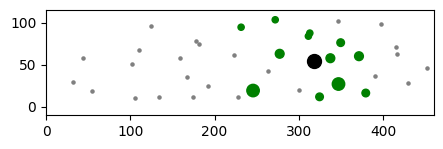

In [84]:
# plt.scatter(l[0],l[1],color = 'black',s = 100)

hfig,ax = plt.subplots(1,figsize=(5,5))

ax.scatter(x = l[0]/1000, y = l[1]/1000, s = 100, color = 'black')


s = df_edges[df_edges['pre'].isin([source]) & df_edges['post_type'].isin(['lf'])]['weight']
ax.scatter(x=[l[0]/1000 for l in l_t],
           y=[l[1]/1000 for l in l_t],
           s=s * 10,color = 'green')

ax.scatter(x=[l[0]/1000 for l in l_not],
           y=[l[1]/1000 for l in l_not],
           s=5,color = 'gray')

ax = plt.gca()
ax.set_xlim(0,460)
ax.set_ylim(-10,115)
ax.set_aspect('equal')

### example cells closest to a certain location or with most syn partners

In [694]:

# target_ids
target_ids = ['id',df_soma[df_soma['cell_type'].isin(['lg'])]['id'].values]

np.argmin(pairwise_distances(df_soma, target_ids = target_ids, dimensions = ['x','z'], source_coords = [250000,50000]))

# df_sub.iloc[np.argmin(abs(df_sub[['x','z']]-[250000,50000]))]

13

In [695]:
target_ids[1][13]

303969144

In [62]:
# look for postsynaptic target with largest number of inputs
df_edges[df_edges['post_type'].isin(['lg'])& df_edges['pre_type'].isin(['mg2'])].groupby('post')['pre'].nunique()

post
43065865      4
44933647      6
44995670      5
45540439      8
45633163      4
45955972      7
128770984     8
129838223     8
131737545     1
132205966     5
214503199    18
215403551     8
215526370    14
300474334     9
301727988    10
301787806    12
301863996     8
302637877    12
303086200     7
303969144     3
304388296     9
305332461    13
388406692    17
390542812    13
472392041    11
474898913    11
558020412     8
559041561     8
560046380     3
560681683     7
561826647     5
563096031    10
644112836     6
645162652     4
645210795     2
647112371     7
647640784     3
650161520     3
651198621     2
652529320     4
Name: pre, dtype: int64

In [23]:
c_id = 393325331
df_edges[df_edges['post'].isin([c_id])& df_edges['pre_type'].isin(['mg1'])]['pre'].values


array([126618353, 127870654, 128737253, 128813171, 213501262, 213590737,
       213669553, 213760634, 299439953, 299496636, 299530386, 472175645,
       472409584, 473647416, 557092670, 558360429, 642905044, 644005141,
       644143297])

In [64]:
# look for postsynaptic target with largest number of inputs
df_edges[df_edges['pre_type'].isin(['mg1'])& df_edges['post_type'].isin(['lf'])].groupby('pre')['post'].nunique()

pre
41579854      5
41843700      8
42201085      3
42632020      5
43622486      2
44517560      2
44548558      2
126618353     5
127870654    10
128737253     8
128813171     6
213501262     7
213590737     5
213669553     7
213760634     7
214411806     8
214550811     3
215030183     4
215480645     4
216081986     6
299392199     4
299439953     9
299496636     7
299530386    12
300131090     5
300210608    10
300380579     4
300459385     7
302143252     4
386114963     4
386224676     8
386643184     7
387909811     9
389085521     4
472114046     6
472175645     9
472282894     4
472409584     9
473723476     5
474111084     2
474236060     8
474373577     5
476167179     5
559551706     8
560744270     9
560819551     6
642905044     8
643848637    11
644005141     8
644143297     7
Name: post, dtype: int64

In [66]:
# df_edges[df_edges['post'].isin([393464000]) & df_edges['pre_type'].isin(['mg1']) ]['pre'].values

df_edges[df_edges['pre'].isin([299530386]) & df_edges['post_type'].isin(['lf'])]['post'].values

array([564038367, 393464000, 134492570, 393325331, 563840037, 565183253,
       394686712,  48807023, 485096532,  48929295, 135870940, 650953193])

In [780]:
# targets with most inputs
target = 214503199 # lg # 393464000 # lf # 
pre_type = 'mg2' # mg2 for lg; mg1 for lf
# df_edges[df_edges['post'].isin([target])]

l = df_soma.loc[df_soma['id'].isin([target]),['x','z']].values[0]

connected = df_edges[df_edges['post'].isin([target])]['pre']
l_t = df_soma.loc[df_soma['id'].isin(connected),['x','z']].values

unconnected = set(df_edges[df_edges['pre_type'].isin([pre_type])]['pre'].unique()) - set(connected)
l_not = df_soma.loc[df_soma['id'].isin(unconnected),['x','z']].values

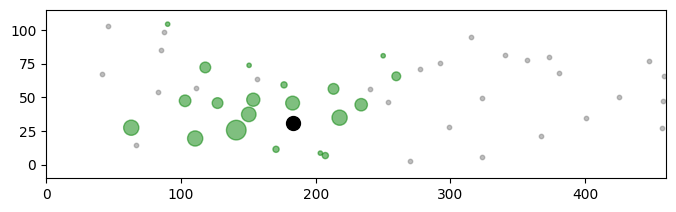

In [781]:
# plt.scatter(l[0],l[1],color = 'black',s = 100)

hfig,ax = plt.subplots(1,figsize=(8,8))

ax.scatter(x = l[0]/1000, y = l[1]/1000, s = 100, color = 'black')

s = df_edges[df_edges['post'].isin([target])]['weight']
ax.scatter(x=[l[0]/1000 for l in l_t],
           y=[l[1]/1000 for l in l_t],
           s=s*10,color = 'green',alpha = 0.5)

ax.scatter(x=[l[0]/1000 for l in l_not],
           y=[l[1]/1000 for l in l_not],
           s=10,color = 'gray',alpha = 0.5)

ax = plt.gca()
ax.set_xlim(0,460)
ax.set_ylim(-10,115)
ax.set_aspect('equal')

### df_syn pre or post

In [570]:
dirpath = Path(settings_dict['save_dir'])
nodefiles = get_cell_filepaths(dirpath)

In [269]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
syn = 'post-synaptic'

In [270]:
df_syn.loc[df_syn['post_type'].isin(['dml']),'post_type']='mli'

df_syn.loc[df_syn['pre_type'].isin(['dml']),'pre_type']='mli'

In [195]:
'''do not convert if soma annotations not converted'''

# for v in ['x','y','z']:
#     df_syn[v] = df_syn[v]/1000
    

'do not convert if soma annotations not converted'

In [196]:
# df_syn['y'] = df_syn['y']*-1

### plot

In [60]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373' 
}

In [61]:
df_soma

id  soma_diam cell_type         x         y        z
0     109461049        NaN       fov       NaN       NaN      NaN
1     109502641     5799.0       mli  334544.0  145676.0  15255.0
2     110418632        NaN        uk       NaN       NaN      NaN
3     110611085        NaN       fov       NaN       NaN      NaN
4     110620163        NaN       fov       NaN       NaN      NaN
...         ...        ...       ...       ...       ...      ...
3550  667942902        NaN       aff       NaN       NaN      NaN
3551  668081112        NaN       aff       NaN       NaN      NaN
3552  668343333        NaN       aff       NaN       NaN      NaN
3553  669119245        NaN       aff       NaN       NaN      NaN
3554  669195832        NaN       aff       NaN       NaN      NaN

[3555 rows x 6 columns]

In [62]:
pre_types_subset = ['mg1']
post_types_subset = ['lf']

for c in df_loc.index:
    df_loc.loc[c,'type'] = cell_types[c]

# df_to_plot = df_loc[(df_loc.index.isin(df_progress[df_progress['completed']>0.9]['id'].values))&df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()
df_to_plot = df_soma[df_soma['type'].isin(['mg1','mg2','lf','lg'])].dropna()

# Initialize an empty DataFrame
df_syn_locs = pd.DataFrame(columns=['x', 'y', 'z', 'cell_type'])

# Loop through cell types and extend the DataFrame
for i,r in df_to_plot.iterrows():
    # print(i,r)
    
    x,y,z = r['soma loc']
    cell = df_syn[(df_syn['pre'].isin([int(i)])) & (df_syn['post_type'].isin(post_types_subset))]
    # cell = ecrest(settings_dict,filepath = nodefiles[i],launch_viewer=False)
    positions = [(s[0]/1000-x,s[1]/1000-y,s[2]/1000-z) for s in list(cell[['x','y','z']].to_records(index=False))]#cell.cell_data['end_points']['post-synaptic']]
   
    # break
    cell_df = pd.DataFrame(positions, columns=['x', 'y', 'z'])  # Create DataFrame for the current cell type
    cell_df['cell_type'] = r['type']  # Add cell type column
    df_syn_locs = pd.concat([df_syn_locs, cell_df], ignore_index=True)  # Concatenate the current cell DataFrame to the main DataFrame

KeyError: '109461049'

In [667]:
g.ax_joint

<AxesSubplot:xlabel='x', ylabel='z'>

/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/kperks/opt/anaconda3/en

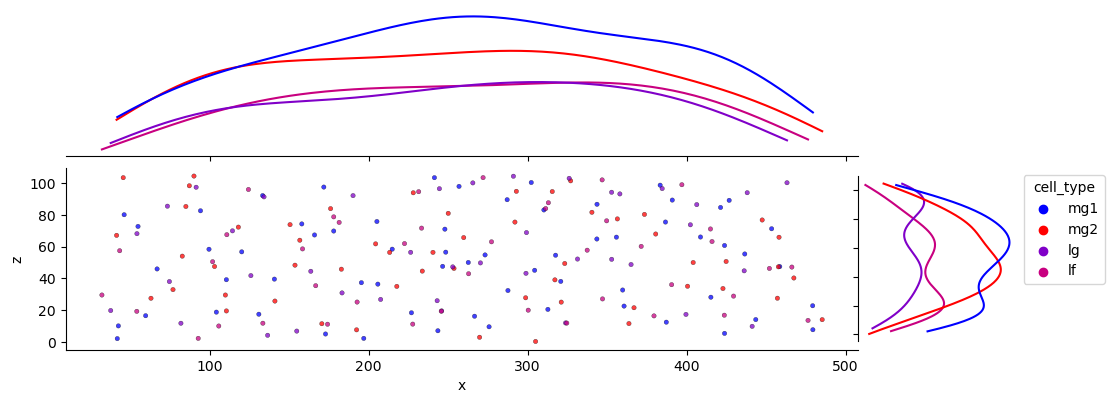

In [63]:
df_scaled = deepcopy(df_soma)
df_scaled['x']= df_scaled['x']/1000
df_scaled['y']= df_scaled['y']/1000 *-1
df_scaled['z']= df_scaled['z']/1000
g = sns.jointplot(data=df_scaled[df_scaled['cell_type'].isin(['mg2','mg1','lg','lf'])], 
                  x="x", y="z", hue="cell_type",s=10,
                  alpha = 0.75, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,cut=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.2, 1))
g.fig.set_size_inches((11, 10))

/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/kperks/opt/anaconda3/en

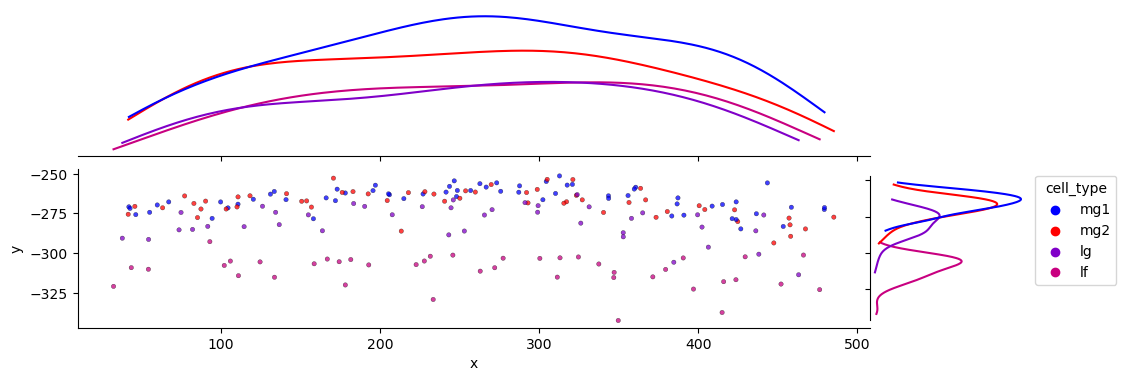

In [64]:

g = sns.jointplot(data=df_scaled[df_scaled['cell_type'].isin(['mg2','mg1','lg','lf'])], 
                  x="x", y="y", hue="cell_type",s=10,
                  alpha = 0.75, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,cut=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.2, 1))
g.fig.set_size_inches((11, 10))

# Connectivity Matrix quantifications

Most appropriately used when focusing on df_edges from either df_syn pre or post, but not the combined df_edges

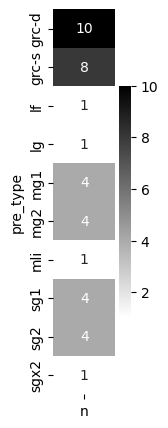

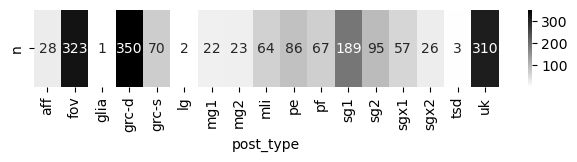

In [617]:
# Calculate the total number of 'pre' nodes for each 'pre_type'
total_pre_nodes = df_edges.groupby('pre_type')['pre'].nunique().reset_index()
total_pre_nodes.loc[:,'number labeled']='n'
total_pre_nodes = total_pre_nodes.pivot(index='pre_type', columns='number labeled', values='pre')

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_nodes, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

###
# Calculate the total number of 'post' nodes for each 'post_type'
total_post_nodes = df_edges.groupby('post_type')['post'].nunique().reset_index()
total_post_nodes.loc[:,'number reconstructed']='n'
total_post_nodes = total_post_nodes.pivot(index='number reconstructed', columns='post_type', values='post')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_nodes, annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

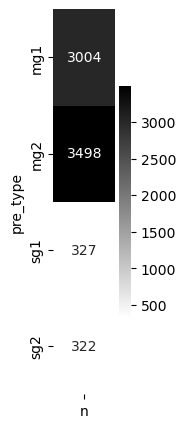

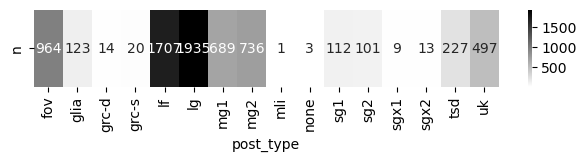

In [200]:
grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()
matrix = grouped.pivot(index='pre_type', columns='post_type', values='weight')#.fillna(0)

### pre
df_pivot = df_edges.groupby('pre_type')['weight'].sum().reset_index()
df_pivot.loc[:,'n']='n'
total_pre_syn = df_pivot.pivot(index='pre_type', columns='n',values='weight')

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_syn, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

### post
df_pivot = df_edges.groupby('post_type')['weight'].sum().reset_index()
df_pivot.loc[:,'n']='n'
total_post_syn = df_pivot.pivot(index='n', columns='post_type',values='weight')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_syn,annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

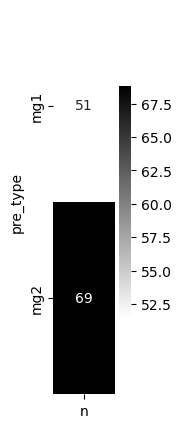

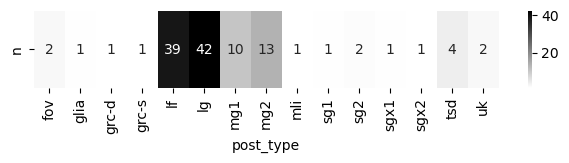

In [24]:
'''mean synapses per cell'''

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_syn / total_pre_nodes, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_syn / total_post_nodes,annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

In [155]:
df_edges[df_edges['pre_type']=='mg1'].sort_values(['post_type','weight'])

pre       post pre_type post_type  weight
2426  472282894  563840037      mg1        lf       1
2486  473723476  306567106      mg1        lf       1
2512  473723476   48929295      mg1        lf       1
2519  128813171  565183253      mg1        lf       1
2520  474236060  650610061      mg1        lf       1
...         ...        ...      ...       ...     ...
71    300459385  214581797      mg1       mg2      13
76    299530386  558254086      mg1       mg2      13
50    299439953  213605530      mg1       mg2      14
10    473723476  216129202      mg1       mg2      20
13     42632020  301339154      mg1       mg2      20

[534 rows x 5 columns]

<Axes: xlabel='weight', ylabel='Density'>

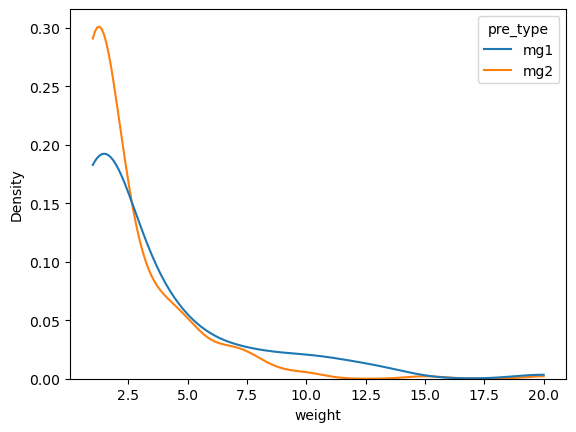

In [88]:
sns.kdeplot(data = df_edges[(df_edges['post_type'].isin(['mg2','mg1'])&df_edges['pre_type'].isin(['mg1','mg2']))], x = 'weight', 
            alpha = 1, hue='pre_type',common_norm=False,cut=0,legend=True)

In [175]:
df_edges[]

pre       post pre_type post_type  weight
2     473631846  305332461      mg2        lg      29
3      41579854  393078033      mg1        lf      29
4     300131090  392814322      mg1        lf      29
5     390294014  652529320      mg2        lf      27
6     213669553  393464000      mg1        lf      21
...         ...        ...      ...       ...     ...
5136  215572949  300459385      mg2       mg1       1
5144  215572949  128737253      mg2       mg1       1
5367  217396339  306738390      mg2        lf       1
5370  217396339  213669553      mg2       mg1       1
5560  217396339  558360429      mg2       mg1       1

[1083 rows x 5 columns]

<Axes: xlabel='post_type', ylabel='pre_type'>

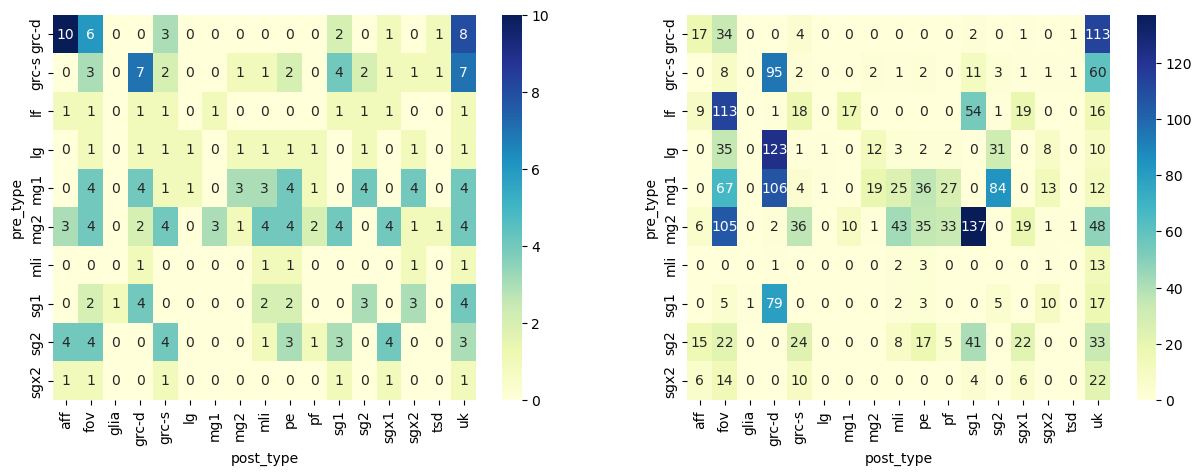

In [618]:
'''
This code does not repeat counting a post cell if more than one pre cell synapses on it
'''
# Calculate the number of 'pre' nodes of each 'pre_type' for each 'post_type'
pre_type_contributions = df_edges.groupby(['pre_type', 'post_type'])['pre'].nunique().unstack(fill_value=0)

# Calculate the number of 'post' nodes of each 'post_type' for each 'pre_type'
post_type_contributions = df_edges.groupby(['pre_type', 'post_type'])['post'].nunique().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(pre_type_contributions, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[0])
sns.heatmap(post_type_contributions, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[1])

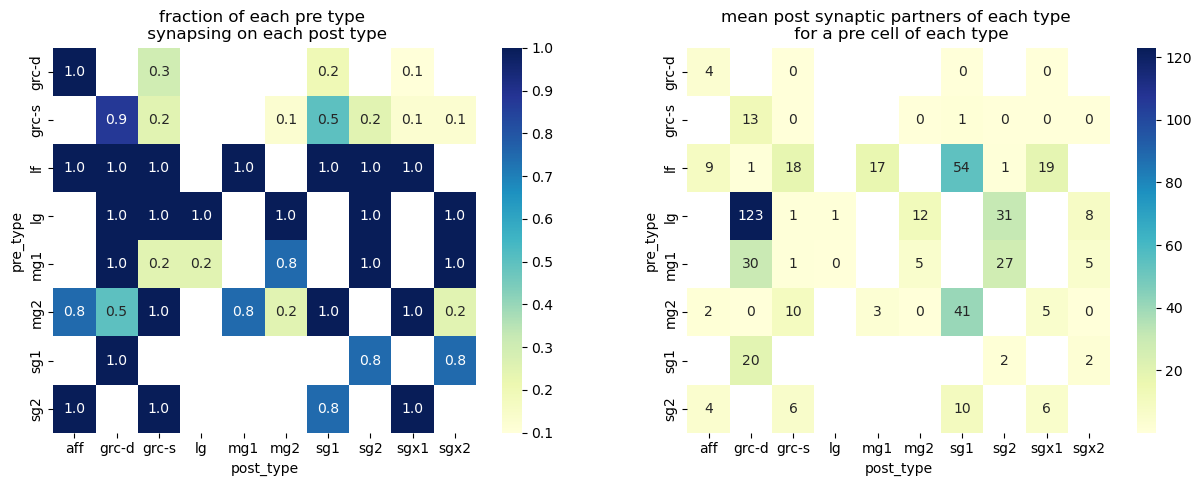

In [445]:
# Calculate the number of edges for each pre-post pair (unique_counts['n_post'])
# Different from the number of unique post nodes
edge_counts = df_edges.groupby(['pre_type', 'post_type','pre'])[['post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['post'].sum().reset_index().rename(columns={'post': 'n_post'})
# The following gives the same as "pre_type_contributions" but with more code: unique_counts['n_pre'] = df_edges.groupby(['pre_type', 'post_type'])[['pre','post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['pre'].sum().reset_index().rename(columns={'pre': 'n_pre'})['n_pre']
pre_counts = df_edges.groupby(['pre_type', 'post_type'])['pre'].nunique().reset_index().rename(columns={'pre': 'n_pre'})
edge_counts['n_pre'] = pre_counts['n_pre']

n_pre_all = [df_edges.groupby(['pre_type'])['pre'].nunique()[p_] for p_ in edge_counts['pre_type']]# unique_counts['pre_type']]

edge_counts['percent_pre'] = edge_counts['n_pre'].div(n_pre_all)
edge_counts['mean_post_count'] = edge_counts['n_post'].div(n_pre_all)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

result_pivot = edge_counts.pivot(index='pre_type', columns='post_type', values='percent_pre')
sns.heatmap(result_pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax = axes[0])

result_pivot = edge_counts.pivot(index='pre_type', columns='post_type', values='mean_post_count')#.fillna(0)
sns.heatmap(result_pivot, annot=True, fmt=".0f", cmap="YlGnBu", ax = axes[1])#,vmax=10)

axes[0].set_title('fraction of each pre type \n synapsing on each post type')
axes[1].set_title('mean post synaptic partners of each type \n for a pre cell of each type');

In [27]:
res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm')

post_type   aff   fov  glia  grc-d  grc-s   lg   mg1  mg2  mli    pe   pf  \
pre_type                                                                    
grc-d      46.0  11.0   NaN    NaN    2.0  NaN   NaN  NaN  NaN   NaN  NaN   
grc-s       NaN   3.0   NaN   64.0    1.0  NaN   NaN  1.0  0.0   1.0  NaN   
lf          5.0  32.0   NaN    0.0    7.0  NaN  14.0  NaN  NaN   NaN  NaN   
lg          NaN  17.0   NaN   37.0    0.0  0.0   NaN  8.0  1.0   0.0  0.0   
mg1         NaN  14.0   NaN   23.0    1.0  0.0   NaN  6.0  9.0   8.0  4.0   
mg2         1.0  19.0   NaN    0.0   13.0  NaN   4.0  0.0  8.0   5.0  4.0   
mli         NaN   NaN   NaN    3.0    NaN  NaN   NaN  NaN  6.0  31.0  NaN   
sg1         NaN   2.0   0.0   70.0    NaN  NaN   NaN  NaN  1.0   1.0  NaN   
sg2        11.0   9.0   NaN    NaN   15.0  NaN   NaN  NaN  5.0   5.0  3.0   
sgx2       35.0  19.0   NaN    NaN   16.0  NaN   NaN  NaN  NaN   NaN  NaN   

post_type   sg1   sg2  sgx1  sgx2  tsd    uk  
pre_type                                      
grc-d       1.0   NaN   0.0   NaN  0.0  41.0  
grc-s       5.0   1.0   0.0   0.0  0.0  23.0  
lf         30.0   0.0   8.0   NaN  NaN   4.0  
lg          NaN  30.0   NaN   3.0  NaN   3.0  
mg1         NaN  29.0   NaN   4.0  NaN   2.0  
mg2        33.0   NaN   3.0   0.0  0.0   6.0  
mli         NaN   NaN   NaN   3.0  NaN  56.0  
sg1         NaN   3.0   NaN  14.0  NaN   8.0  
sg2        23.0   NaN  19.0   NaN  NaN  11.0  
sgx2        4.0   NaN   5.0   NaN  NaN  21.0

In [91]:
# row_order = ['grc-d', 'grc-s', 'sg1', 'sg2', 'mg1', 'mg2', 'lg', 'lf']
# col_order = ['aff', 'grc-d', 'grc-s', 'sg1', 'sg2', 'mg1', 'mg2']
col_order = ['grc-d', 'grc-s', 'sg1', 'sg2', 'mg1', 'mg2', 'lg', 'lf']
row_order = ['aff', 'grc-d', 'grc-s', 'sg1', 'sg2', 'mg1', 'mg2']
mask = df_edges['pre_type'].isin(row_order) & df_edges['post_type'].isin(col_order)

res = df_edges[mask].groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges[mask].groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges[mask].groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = np.round(res.weight / syn_total *100)
res.loc[:,'weight_per_cell'] = res.weight / n_pre
# res.loc[:,'weight_per_pair'] = res.weight / n_post #* does not work because this is div by all npost, not those in that pairing

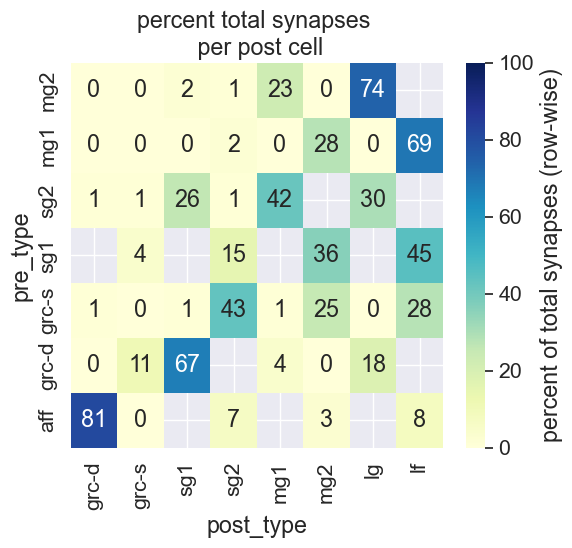

In [92]:
sns.set(font_scale=1.4)
res_weightnorm = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm')#.columns
res_weightnorm = res_weightnorm.reindex(index=row_order[::-1], columns=col_order)

fig, axes = plt.subplots(1,figsize=(6,5))

sns.heatmap(res_weightnorm,#.fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,vmax=100, ax = axes,
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

# axes[0].set_title('mean synapses per pre cell \n on each post type')
# axes[1].set_title('percent total synapses \n per pre cell');

axes.set_title('percent total synapses \n per post cell');


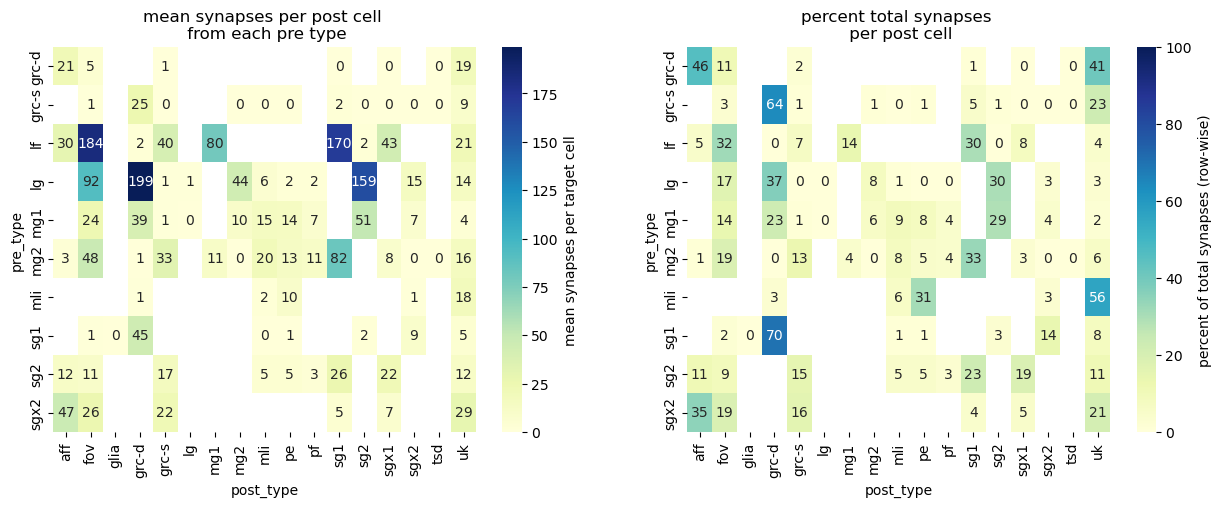

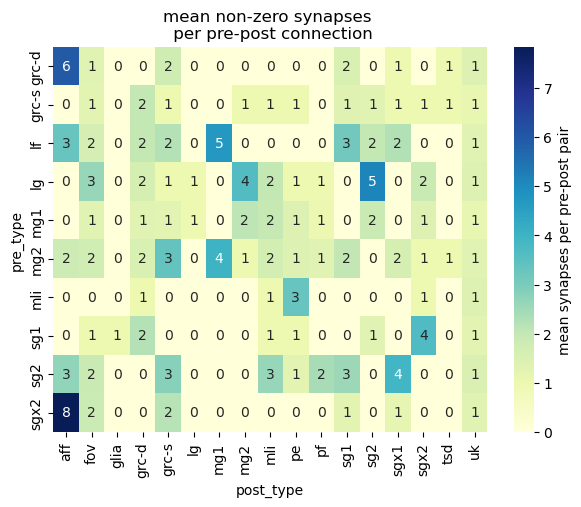

In [ ]:
# hfig,ax = plt.subplots(1,figsize=(5,2))
fig, axes = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_per_cell'),#.fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,ax=axes[0], fmt=".0f", #,vmax=100
           cbar_kws={'label': 'mean synapses per target cell'})

res_weightnorm = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm')#.columns


res_weightnorm.reindex(index=row_order, columns=col_order)


sns.heatmap(res_weightnorm,#.fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,vmax=100,ax=axes[1], #
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

# axes[0].set_title('mean synapses per pre cell \n on each post type')
# axes[1].set_title('percent total synapses \n per pre cell');

axes[0].set_title('mean synapses per post cell \n from each pre type')
axes[1].set_title('percent total synapses \n per post cell');


edge_counts = df_edges.groupby(['pre_type', 'post_type','pre'])[['post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['post'].sum().reset_index().rename(columns={'post': 'n_post'})
res.loc[:,'n_edges']=edge_counts['n_post'].values
res.loc[:,'u_edges']=res['weight']/res['n_edges']
fig, axes = plt.subplots(1, figsize=(7, 5))
sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='u_edges').fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,ax=axes, fmt=".0f",
           cbar_kws={'label': 'mean synapses per pre-post pair'});
axes.set_title('mean non-zero synapses \n per pre-post connection');

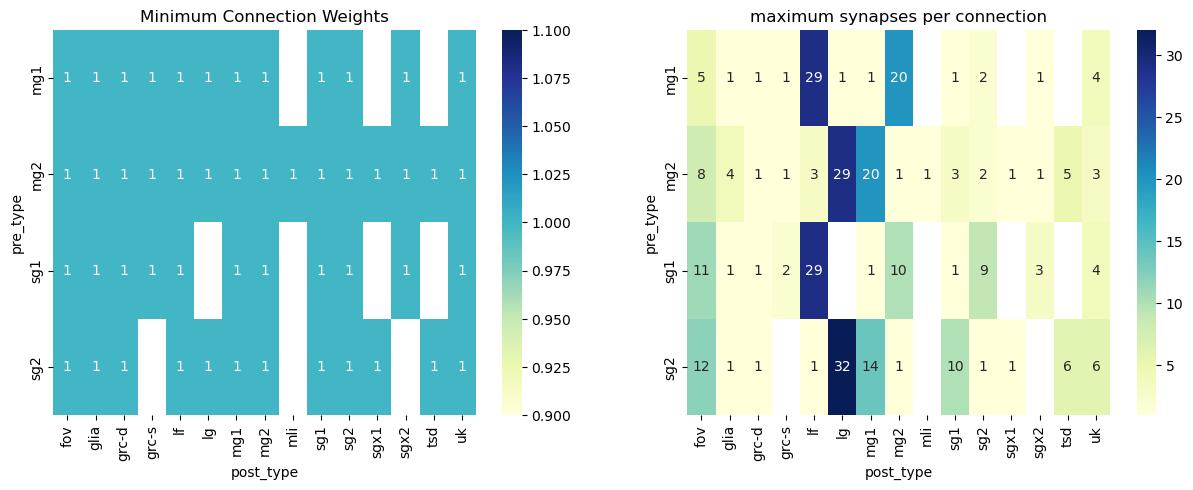

In [133]:

grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].agg(['mean', 'min', 'max']).reset_index()

# Pivot the DataFrame to get matrices for median, min, and max weights
mean_matrix = grouped.pivot(index='pre_type', columns='post_type', values='mean')
min_matrix = grouped.pivot(index='pre_type', columns='post_type', values='min')
max_matrix = grouped.pivot(index='pre_type', columns='post_type', values='max')

# Create subplots for median, min, and max matrices
fig, axes = plt.subplots(1,2, figsize=(15, 5))

# Set titles for subplots
# axes[2].set_title('mean non-zero synapses \n per pre-post connection');
axes[0].set_title('Minimum Connection Weights')
axes[1].set_title('maximum synapses per connection')

# Plot the heatmaps for median, min, and max matrices
# sns.heatmap(mean_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[2])
sns.heatmap(min_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[0])
sns.heatmap(max_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[1])

# plt.tight_layout()
plt.show();

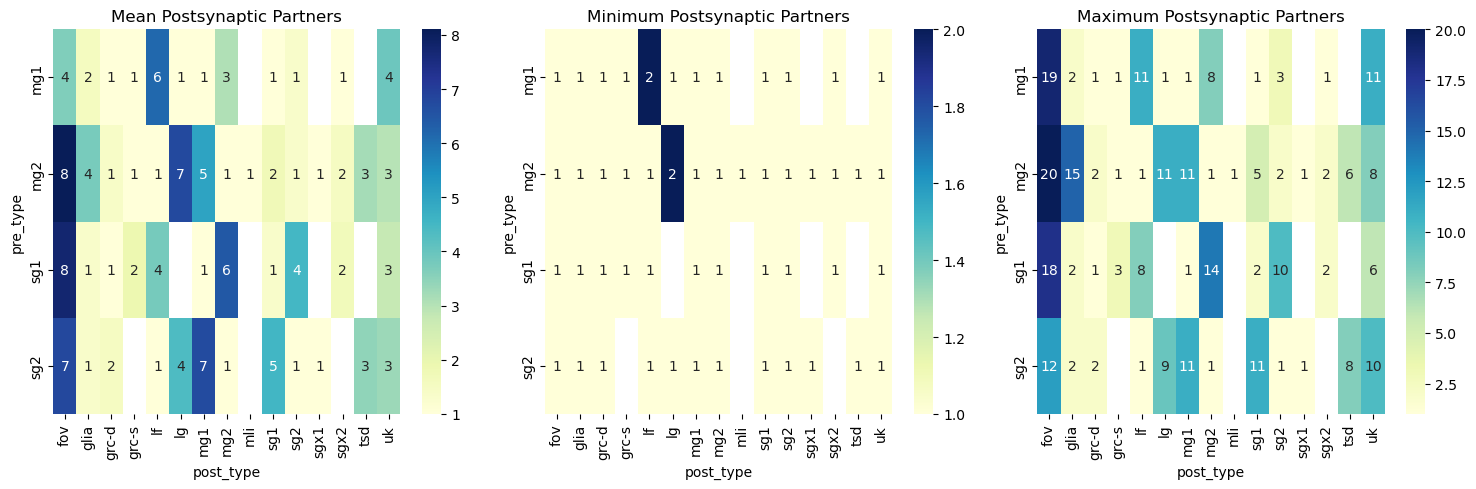

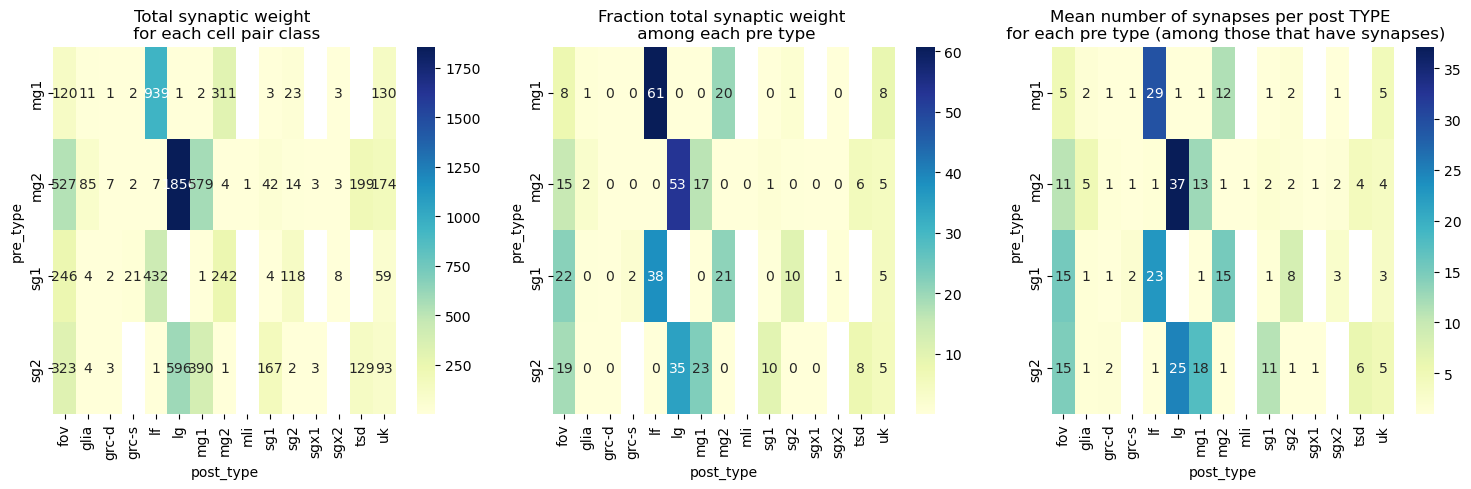

In [134]:
'''
connection partners only among pre cells that synapse on that type
'''

# Calculate the average number of unique 'post' cells for each 'pre_type'
average_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).mean().unstack() # average_counts = average_counts.applymap(lambda x: f'{x:.1f}').astype(float)
min_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).min().unstack() # min_counts = min_counts.applymap(lambda x: f'{x:.1f}').astype(float)
max_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).max().unstack() # max_counts = max_counts.applymap(lambda x: f'{x:.1f}').astype(float)

# Create subplots for median, min, and max matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Set titles for subplots
axes[0].set_title('Mean Postsynaptic Partners')
axes[1].set_title('Minimum Postsynaptic Partners')
axes[2].set_title('Maximum Postsynaptic Partners')

# Plot the heatmaps for median, min, and max matrices
sns.heatmap(average_counts, annot=True, cmap="YlGnBu", ax=axes[0], fmt=".0f")
sns.heatmap(min_counts, annot=True, cmap="YlGnBu", ax=axes[1], fmt=".0f")
sns.heatmap(max_counts, annot=True, cmap="YlGnBu", ax=axes[2], fmt=".0f")

plt.tight_layout()
# plt.show();

grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()

# Pivot the DataFrame to get the desired matrix
matrix = grouped.pivot(index='pre_type', columns='post_type', values='weight')#.fillna(0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(matrix, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])

matrix_normalized = matrix.div(matrix.sum(axis=1), axis=0).div(0.01)
sns.heatmap(matrix_normalized, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

average_weight = df_edges.groupby(['pre_type', 'post_type', 'pre'])['weight'].sum().groupby(['pre_type', 'post_type']).mean().unstack() # average_counts = average_counts.applymap(lambda x: f'{x:.1f}').astype(float)
sns.heatmap(average_weight, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[2])

# Set titles for subplots
axes[0].set_title('Total synaptic weight \n for each cell pair class')
axes[1].set_title('Fraction total synaptic weight \n among each pre type')
axes[2].set_title('Mean number of synapses per post TYPE \n for each pre type (among those that have synapses)')

plt.tight_layout();

## As stacked bar

In [143]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'mli':'#e6e6e6',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#ccccff',
    'uk':'#999999',
    'fov':'#000000',
    'focal types':'#33cc33',
    'pf':'#004d00',
    'pe':'#800000',
    'glia':'#666666'
}

syn_hatch = {
    'sgx1':'', #'#996633',
    'sgx2':'',
    'sg1':'',
    'sg2':'',
    'grc-d':'',
    'grc-s':'',
    'mli':'',
    'mg1':'',
    'mg2':'',
    'lg':'',
    'lf':'',
    'aff':'/',
    'tsd':'',
    'uk':'',
    'fov':'',
    'focal types':'',
    'pf':'x',
    'pe':'0',
    'glia':'*'
}

In [144]:
df_edges.groupby(['pre_type'])[['pre']].nunique() #sum(numeric_only=True)

pre
pre_type     
aff         1
grc-d      18
grc-s      11
mg1        51
mg2        50
mli         6
pe          7
pf         35
sg1        41
sg2        39
sgx1        7
sgx2        2
tsd         2
uk          2

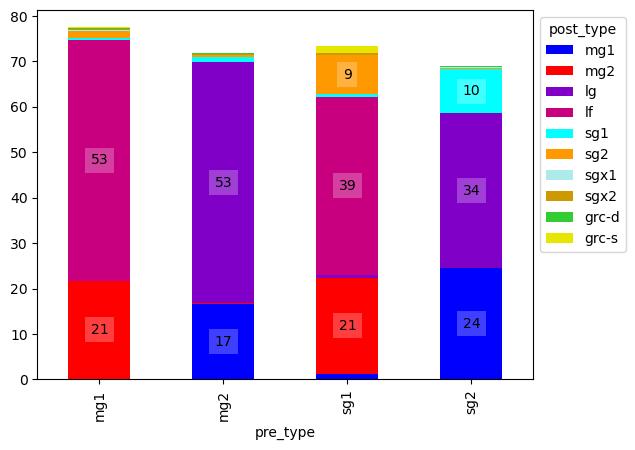

In [145]:
res = df_edges.groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges.groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges.groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = res.weight / syn_total *100
# res.loc[:,'weight_norm'] = res.weight / n_pre

matrix_normalized = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm').fillna(0) #weight_norm


if syn == 'post-synaptic':
    order_pre = ['mg1','mg2','sg1','sg2']#['grc-d','sg2','mg2','aff','grc-s','sg1','mg1','mli','pf','pe','tsd']#,'dml']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s']#['grc-d','sgx2','sg2','mg2','lf','grc-s','sgx1','sg1','mg1','lg','mli','pf','pe','tsd','uk','fov','glia']
if syn == 'pre-synaptic':
    order_pre = ['grc-d','mg2','lf','grc-s','mg1','lg']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['aff','grc-d','sgx2','sg2','mg2','grc-s','sgx1','sg1','mg1','mli','pf','pe','uk','fov','tsd']

ax = matrix_normalized.loc[order_pre,order_post].plot.bar(stacked=True,color = syn_colors)#, hatch=[syn_hatch[v] for v in order_post])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.25, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))

In [35]:
matrix_normalized

post_type        aff        fov      grc-d      grc-s        mg1       mg2  \
pre_type                                                                     
grc-d      39.534884   5.813953   0.000000   0.000000   0.000000  0.000000   
grc-s       0.000000   1.968504  63.779528   0.393701   0.000000  0.000000   
lf          5.281690  24.471831   0.352113   7.042254  15.140845  0.000000   
mg1         0.000000  17.782427  23.430962   0.000000   0.000000  8.158996   
mg2         1.030928  20.446735   0.343643   6.872852   8.591065  0.171821   
sg2         7.239819   6.334842   0.000000  21.719457   0.000000  0.000000   

post_type       mli        pe        pf        sg1        sg2       sgx1  \
pre_type                                                                   
grc-d      0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
grc-s      0.393701  1.181102  0.000000   5.511811   0.000000   0.393701   
lf         0.000000  0.000000  0.000000  28.521127   0.000000   6.866197   
mg1        9.414226  7.322176  4.811715   0.000000  20.502092   0.000000   
mg2        5.326460  2.061856  0.343643  34.020619   0.000000   0.859107   
sg2        9.502262  8.597285  5.429864  14.027149   0.000000  10.859729   

post_type      sgx2       tsd         uk  
pre_type                                  
grc-d      0.000000  0.000000  54.651163  
grc-s      0.000000  0.000000  26.377953  
lf         0.000000  0.000000  12.323944  
mg1        2.719665  0.000000   5.857741  
mg2        0.000000  0.171821  19.759450  
sg2        0.000000  0.000000  16.289593

In [139]:
columns_to_combine=['grc-d', 'grc-s',  'mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2','lf', 'lg'] #

In [140]:
df_combined_col = deepcopy(matrix_normalized)
df_combined_col[columns_to_combine].sum(axis=1)
df_combined_col.loc[:,'focal types'] = df_combined_col[columns_to_combine].sum(axis=1)

In [141]:
df_combined_col.drop(columns=columns_to_combine)

post_type        fov      glia       mli       tsd        uk  focal types
pre_type                                                                 
mg1         7.761966  0.711514  0.000000  0.000000  8.408797    83.117723
mg2        15.044248  2.426492  0.028547  5.680845  4.967171    71.852698
sg1        21.635884  0.351803  0.000000  0.000000  5.189094    72.823219
sg2        18.866822  0.233645  0.000000  7.535047  5.432243    67.932243

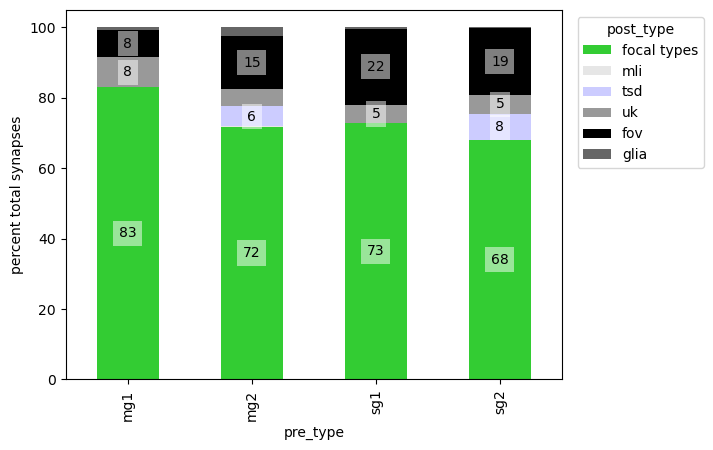

In [142]:

df_combined_col = deepcopy(matrix_normalized)
df_combined_col['focal types'] = df_combined_col[columns_to_combine].sum(axis=1)

# Drop the specified columns
df_combined_col.drop(columns=columns_to_combine,inplace=True)

order_pre = ['mg1','mg2','sg1','sg2']#['aff','grc-d','sg2','mg2','grc-s','sg1','mg1','mli','pf','pe','tsd']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
order_post = ['focal types','mli','tsd','uk','fov','glia']

ax = df_combined_col.loc[order_pre,order_post].plot.bar(stacked=True,color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylabel('percent total synapses');

In [197]:
matrix_normalized.index

Index(['grc-d', 'grc-s', 'lf', 'lg', 'mg1', 'mg2', 'mli', 'sg1', 'sg2',
       'sgx2'],
      dtype='object', name='pre_type')

# divergence and convergence

## post synaptic

In [22]:
cell_color = {'aff':'#568D00',
             'lg':'#BB00FF',
              'lf':'#FF00BC',
              'mg1':'#0000FF',
              'mg2':'#FF0000',
              'pf':'#3F3F3F'
             }

In [23]:
desired_combinations = [
    ('mg1', 'mg2'),
    ('mg1', 'lf'),
    ('mg2', 'mg1'),
    ('mg2', 'lg')
]
# filtered_df = df_edges[df_edges[['pre_type', 'post_type']].apply(tuple, axis=1).isin(desired_combinations)]


In [26]:
# list(filtered_df.groupby(['pre_type','pre']))

# Initialize an empty DataFrame to store the results
divergence_counts = pd.DataFrame(columns=['pre_type', 'post_type', 'pre', 'divergence_count'])

# Iterate over each desired combination
for pre_type, post_type in desired_combinations:
    # Filter the DataFrame for the current combination
    subset_df = df_edges[(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    
    # Group by pre and count unique post cells for each pre cell
    # subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['post'].nunique().reset_index()
    # subset_divergence_counts.rename(columns={'post': 'divergence_count'}, inplace=True)

    # Group by pre and count synapse total for each pre cell
    subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['weight'].sum().reset_index()
    subset_divergence_counts.rename(columns={'weight': 'divergence_count'}, inplace=True)
    
    # Add pre_type and post_type columns
    subset_divergence_counts['post_type'] = post_type
    
    # Append the subset DataFrame to the results DataFrame
    divergence_counts = pd.concat([divergence_counts, subset_divergence_counts])

# Display the resulting DataFrame
divergence_counts.head()
divergence_counts[divergence_counts['divergence_count'] != 0]

pre_type post_type        pre divergence_count
0       mg1       mg2   42632020               29
1       mg1       mg2   44548558                4
2       mg1       mg2  126618353               18
3       mg1       mg2  127870654               29
4       mg1       mg2  128737253                1
..      ...       ...        ...              ...
45      mg2        lg  642458763               27
46      mg2        lg  644823522               20
47      mg2        lg  644824766               30
48      mg2        lg  646634295               50
49      mg2        lg  647809492               64

[193 rows x 4 columns]

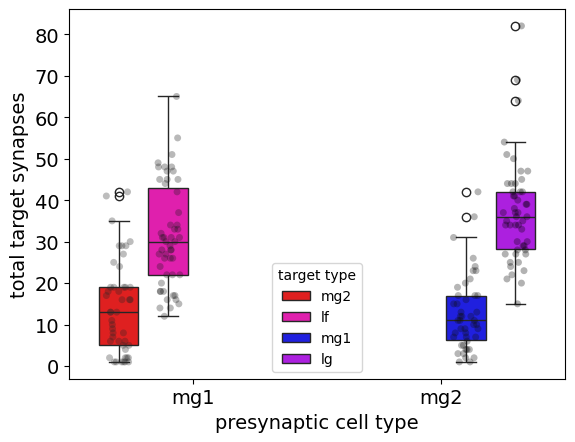

In [32]:

ax = sns.boxplot(data=divergence_counts,x = 'pre_type',y='divergence_count',hue='post_type',palette=cell_color,dodge=True,gap=0.2)#,k_depth='full')
sns.stripplot(ax = ax, data=divergence_counts,x = 'pre_type',y='divergence_count',hue='post_type',dodge=True,jitter=0.2,alpha=0.3,legend=False,palette='dark:black')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

leg = ax.axes.get_legend()
leg.set_title('target type')

# ax.set_ylabel('number of target cells')
ax.set_ylabel('total target synapses')
ax.set_xlabel('presynaptic cell type')

plt.savefig('/Users/kperks/Downloads/divergence_weight.svg') 

In [292]:
df_edges

pre       post pre_type post_type  weight
0     306461085  301863996      sg2        lg      32
1     130781211  215526370      sg2        lg      32
2     300131090  392814322      mg1        lf      29
3      41579854  393078033      sg1        lf      29
4     473631846  305332461      mg2        lg      29
...         ...        ...      ...       ...     ...
6419  299589324   45356019      sg1       sg2       1
6420  299530386  654448841      mg1        uk       1
6421  299530386  652159066      mg1       fov       1
6422  299530386  652128578      mg1       fov       1
6423  649572893  649510440      sg2       fov       1

[6424 rows x 5 columns]

In [29]:
# list(filtered_df.groupby(['pre_type','pre']))

# Initialize an empty DataFrame to store the results
convergence_counts = pd.DataFrame(columns=['pre_type', 'post_type', 'post', 'convergence_count'])

# Iterate over each desired combination
for pre_type, post_type in desired_combinations:
    # Filter the DataFrame for the current combination
    subset_df = df_edges[(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    
    # # Group by pre and count unique post cells for each pre cell
    # subset_convergence_counts = subset_df.groupby(['pre_type', 'post'])['pre'].nunique().reset_index()
    # subset_convergence_counts.rename(columns={'pre': 'convergence_count'}, inplace=True)

    # Group by pre and count synapse total for each pre cell
    subset_convergence_counts = subset_df.groupby(['pre_type', 'post'])['weight'].sum().reset_index()
    subset_convergence_counts.rename(columns={'weight': 'convergence_count'}, inplace=True)
    
    # Add pre_type and post_type columns
    subset_convergence_counts['post_type'] = post_type
    
    # Append the subset DataFrame to the results DataFrame
    convergence_counts = pd.concat([convergence_counts, subset_convergence_counts])

# Display the resulting DataFrame
convergence_counts.head()
convergence_counts[convergence_counts['convergence_count'] != 0]

pre_type post_type       post convergence_count
0       mg1       mg2   40448913                 5
1       mg1       mg2   40665046                 3
2       mg1       mg2   41825714                 7
3       mg1       mg2   42769344                 7
4       mg1       mg2   45727047                 7
..      ...       ...        ...               ...
35      mg2        lg  645210795                 9
36      mg2        lg  647112371                29
37      mg2        lg  647640784                11
38      mg2        lg  650161520                42
39      mg2        lg  652529320                60

[183 rows x 4 columns]

In [30]:
convergence_counts[(convergence_counts['pre_type'].isin(['mg1','mg2'])) & (convergence_counts['post_type'].isin(['lg','lf']))].sort_values('convergence_count')

pre_type post_type       post convergence_count
29      mg1        lf  397396859                 1
8       mg2        lg  131737545                 1
33      mg1        lf  485096532                 3
6       mg1        lf   50677331                 3
29      mg2        lg  560046380                 3
..      ...       ...        ...               ...
10      mg2        lg  214503199               101
24      mg1        lf  393325331               112
26      mg2        lg  476044282               112
21      mg2        lg  305332461               113
12      mg2        lg  215526370               121

[82 rows x 4 columns]

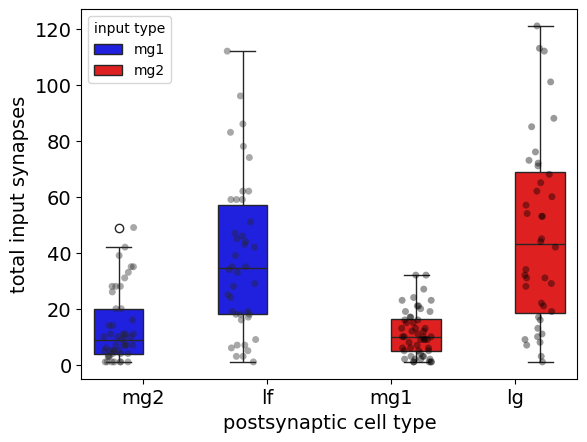

In [33]:

ax = sns.boxplot(data=convergence_counts,x = 'post_type',y='convergence_count',hue='pre_type',palette=cell_color,dodge=0.5)
sns.stripplot(ax = ax, data=convergence_counts,x = 'post_type',y='convergence_count',hue='pre_type',dodge=True,jitter=0.25,alpha=0.4,legend=False,palette='dark:black')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

leg = ax.axes.get_legend()
leg.set_title('input type')

# ax.set_ylabel('number of input cells')
ax.set_ylabel('total input synapses')
ax.set_xlabel('postsynaptic cell type')

plt.savefig('/Users/kperks/Downloads/convergence_weight.svg') 

## pre synaptic

In [502]:

syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mli':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088'
}

In [465]:
df_progress[(df_progress['type'].isin(['lg']))].sort_values('todo').head(100) 

id   type n_syn done todo  completed
0  565013265  grc-s    70   70    0   1.000000
0  389812730  grc-s    80   80    0   1.000000
0  392042360  grc-s    57   57    0   1.000000
0  305051491  grc-s    51   47    4   0.921569
0  306242528  grc-s    47   29   18   0.617021
0   45120720  grc-s    25    3   22   0.120000
0  307621813  grc-s    48    5   43   0.104167
0  219161561  grc-s    90   25   65   0.277778

In [105]:
pre_list = ['mg1','mg2','sg1','sg2','grc-d','grc-s','lg','lf']
post_list = ['aff','grc-s','sg1','mg1','grc-d','sg2','mg2']
desired_combinations = [(pre, post) for pre in pre_list for post in post_list]

# filtered_df = df_edges[df_edges[['pre_type', 'post_type']].apply(tuple, axis=1).isin(desired_combinations)]
example_mask = (df_edges['pre'].isin([214581797,299496636,218095913,385434515,306461085,128832297,387554847,393325331,301787806,226019332,223881844,482680782,565013265,389812730,392042360])) #214581797

In [106]:
divergence_counts = pd.DataFrame(columns=['pre_type', 'post_type', 'pre', 'divergence_count'])
# Iterate over each desired combination
for pre_type, post_type in desired_combinations:
    # Filter the DataFrame for the current combination
    subset_df = df_edges[example_mask&(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    if len(subset_df)==0:
        subset_divergence_counts = pd.DataFrame({'pre_type':pre_type,
                                                 'post_type':post_type,
                                                 'pre':df_edges[example_mask&(df_edges['pre_type'] == pre_type)]['pre'].unique(),
                                                 'divergence_count':0})    
    # Group by pre and count unique post cells for each pre cell

    else:
        subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['post'].nunique().reset_index()
        subset_divergence_counts.rename(columns={'post': 'divergence_count'}, inplace=True)
        
        # Group by pre and count synapse total for each pre cell
        subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['weight'].sum().reset_index()
        subset_divergence_counts.rename(columns={'weight': 'divergence_count'}, inplace=True)
        
        # Add pre_type and post_type columns
        subset_divergence_counts['post_type'] = post_type

    # Append the subset DataFrame to the results DataFrame
    divergence_counts = pd.concat([divergence_counts, subset_divergence_counts])

# Display the resulting DataFrame
divergence_counts.head()
# divergence_counts[divergence_counts['divergence_count'] != 0]

pre_type post_type        pre divergence_count
0      mg1       aff  299496636                0
0      mg1     grc-s  299496636                0
0      mg1       sg1  299496636                0
0      mg1       mg1  299496636                0
0      mg1     grc-d  299496636              111

In [107]:
divergence_counts['post_type_cat'] = pd.Categorical(divergence_counts['post_type'], categories=post_list, ordered=True)

# Sort the DataFrame based on the categorical 'x' column
sorted_data = divergence_counts.sort_values(by='post_type_cat')

In [111]:
sorted_data[sorted_data['pre_type'].isin(['grc-s'])]#['pre'].unique()

pre_type post_type        pre divergence_count post_type_cat
2    grc-s       aff  392042360                0           aff
1    grc-s       aff  389812730                0           aff
0    grc-s       aff  565013265                0           aff
0    grc-s     grc-s  565013265                1         grc-s
0    grc-s       sg1  389812730                2           sg1
1    grc-s       sg1  565013265                2           sg1
0    grc-s       mg1  565013265                0           mg1
1    grc-s       mg1  389812730                0           mg1
2    grc-s       mg1  392042360                0           mg1
0    grc-s     grc-d  389812730               57         grc-d
1    grc-s     grc-d  392042360               49         grc-d
2    grc-s     grc-d  565013265               41         grc-d
0    grc-s       sg2  565013265                0           sg2
1    grc-s       sg2  389812730                0           sg2
2    grc-s       sg2  392042360                0           sg2
2    grc-s       mg2  392042360                0           mg2
1    grc-s       mg2  389812730                0           mg2
0    grc-s       mg2  565013265                0           mg2

Text(0, 0.5, 'total synapses per postsynaptic cell')

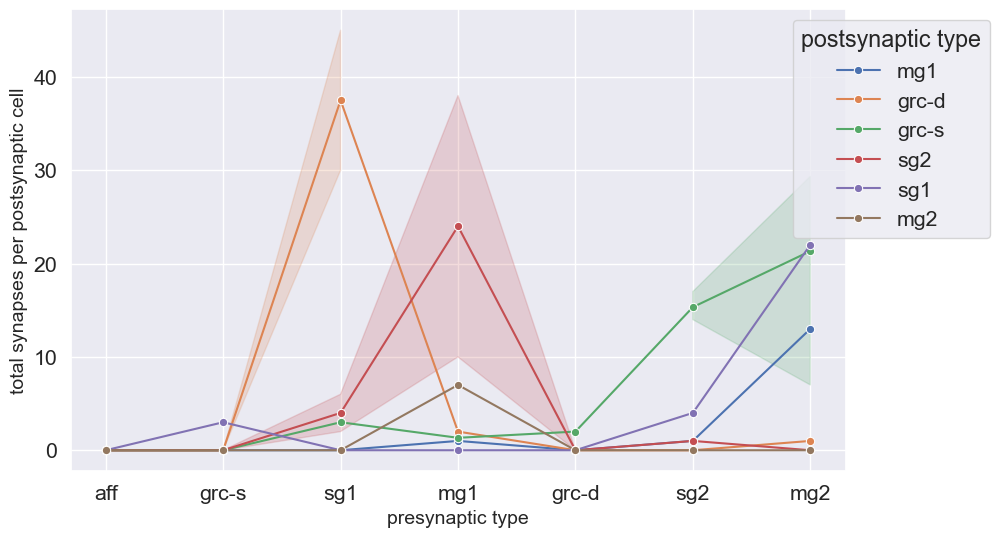

In [672]:
hfig,ax = plt.subplots(figsize=(10,6))
# Convert 'x' column to categorical with desired order
# divergence_counts['post_type_cat'] = pd.Categorical(divergence_counts['post_type'], categories=post_list, ordered=True)

# # Sort the DataFrame based on the categorical 'x' column
# sorted_data = divergence_counts.sort_values(by='post_type_cat')

g = sns.lineplot(ax=ax,data = sorted_data, x='post_type',y='divergence_count',hue='pre_type', marker='o')
# g = sns.stripplot(ax=ax,data=divergence_counts, x='post_type',y='divergence_count',jitter=0.15,
#               hue='pre_type',size=10,alpha=1,linewidth=1,order = post_list,palette = syn_colors)
ax.get_legend().set_title('postsynaptic type')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))
ax.set_xlabel('presynaptic type',fontsize=14)
ax.set_ylabel('total synapses per postsynaptic cell',fontsize=14)
# g.set_yticklabels(g.get_yticks(), size = 14);
# g.set_xticklabels(fontsize = 14);

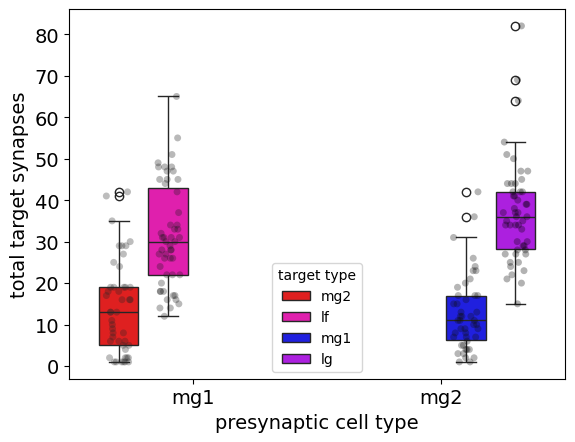

In [32]:

ax = sns.boxplot(data=divergence_counts,x = 'pre_type',y='divergence_count',hue='post_type',palette=cell_color,dodge=True,gap=0.2)#,k_depth='full')
sns.stripplot(ax = ax, data=divergence_counts,x = 'pre_type',y='divergence_count',hue='post_type',dodge=True,jitter=0.2,alpha=0.3,legend=False,palette='dark:black')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

leg = ax.axes.get_legend()
leg.set_title('target type')

# ax.set_ylabel('number of target cells')
ax.set_ylabel('total target synapses')
ax.set_xlabel('presynaptic cell type')

plt.savefig('/Users/kperks/Downloads/divergence_weight.svg') 

# shared input

In [314]:
# Initialize an empty DataFrame to store the results
# shared_input_df = pd.DataFrame(columns=['post1', 'post2', 'shared_input', 'distance', 'post_type'])
shared_input_results = []

desired_combinations = [
    ('mg1', 'mg2'),
    ('mg1', 'lf'),
    ('mg2', 'mg1'),
    ('mg2', 'lg')
]
for pre_type, post_type in desired_combinations:
    # Group the DataFrame by 'post_type'
    subset_df = df_edges[(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    grouped = subset_df.groupby('post_type')

    # Iterate over each group
    for post_type, group in grouped:
        # Get all unique combinations of 'post' cells
        post_combinations = combinations(group['post'].unique(), 2)
        
        # Iterate over each pair of 'post' cells
        for post1, post2 in post_combinations:
            # Find the common 'pre' cells for the current pair
            shared_input = len(set(group[group['post'] == post1]['pre']).intersection(group[group['post'] == post2]['pre']))
            distance = pairwise_distances(df_soma, target_ids = ['id',[post2]], dimensions = ['x','y','z'], source_ids = ['id',[post1]])
            
            # Append the result to the DataFrame
            # shared_input_df = shared_input_df.append({'post1': post1, 'post2': post2, 'shared_input': shared_input, 'distance': distance, 'post_type': post_type}, ignore_index=True)
            shared_input_results.append({'post1': post1, 'post2': post2, 'shared_input': shared_input, 'distance': distance[0]/1000, 'post_type': post_type})

# Create the DataFrame from the list
shared_input_df = pd.DataFrame(shared_input_results)    
# Display the resulting DataFrame
shared_input_df.head()

post1      post2  shared_input    distance post_type
0  216129202  301339154             0  297.717008       mg2
1  216129202  213605530             4  102.594803       mg2
2  216129202  558254086             1  123.103077       mg2
3  216129202  299404889             2  147.606389       mg2
4  216129202  214581797             0  183.018886       mg2

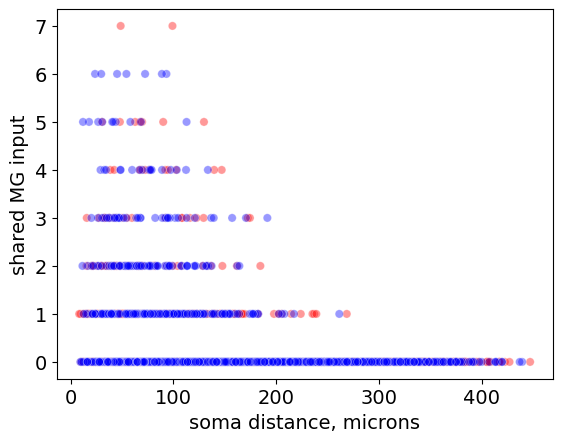

In [327]:
ax = sns.scatterplot(data = shared_input_df[shared_input_df['post_type'].isin(['mg1','mg2'])],x='distance',y='shared_input',alpha = 0.4,hue='post_type',palette=cell_color,legend=False)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

ax.set_ylabel('shared MG input')
ax.set_xlabel('soma distance, microns')

plt.savefig('/Users/kperks/Downloads/shared_input_mg.svg') 

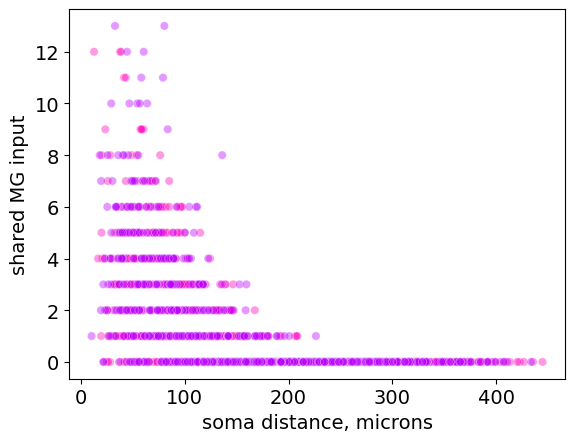

In [328]:
ax = sns.scatterplot(data = shared_input_df[shared_input_df['post_type'].isin(['lg','lf'])],x='distance',y='shared_input',alpha = 0.4,hue='post_type',palette=cell_color,legend=False)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

ax.set_ylabel('shared MG input')
ax.set_xlabel('soma distance, microns')


plt.savefig('/Users/kperks/Downloads/shared_input_out.svg') 

# cell variability among most completed

In [361]:

def typed_progress_df(df_edges,pre_type):

    res = df_edges[df_edges['pre_type'].isin(pre_type)].groupby(
        ['pre','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
    denom = res.groupby('pre')['weight'].sum()

    # res.weight = np.round(res.weight / denom *100)

    data = res.reset_index(level=[0,1]).fillna(0)
    
    return data

## stacked bar

In [110]:
res = df_edges.groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges.groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges.groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = res.weight / syn_total *100

matrix_normalized = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm').fillna(0)

In [363]:
matrix_normalized

post_type       fov     grc-s        lf         lg       mg1        mg2  \
pre_type                                                                  
mli        9.370425  0.732064  7.467057  10.248902  9.809663  13.469985   

post_type        mli        pe        pf        sg1       sg2      sgx1  \
pre_type                                                                  
mli        12.445095  0.146413  0.292826  11.859444  5.856515  0.292826   

post_type       tsd        uk  
pre_type                       
mli        2.781845  15.22694

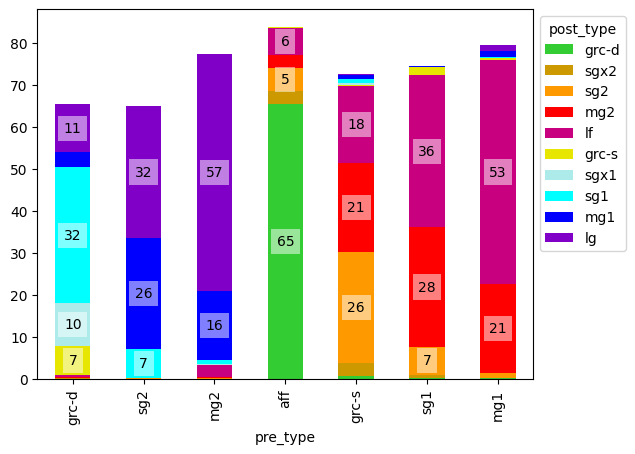

In [111]:
if syn == 'post-synaptic':
    order_pre = ['grc-d','sg2','mg2','aff','grc-s','sg1','mg1']#,'dml']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['grc-d','sgx2','sg2','mg2','lf','grc-s','sgx1','sg1','mg1','lg']#,'dml','tsd','uk','fov']
if syn == 'pre-synaptic':
    order_pre = ['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['aff','grc-d','sgx2','sg2','mg2','grc-s','sgx1','sg1','mg1']

ax = matrix_normalized.loc[order_pre,order_post].plot.bar(stacked=True,color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))

## bar

In [129]:
pre_type = ['grc-d']
data = typed_progress_df(df_edges,pre_type)
ax = sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
# ax = sns.barplot(data = df_edges[df_edges['pre_type'].isin(pre_type)], y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
# plt.ylim(0,100);
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

NameError: name 'typed_progress_df' is not defined

In [221]:
data['pre'].unique()

array([290291065, 297177312, 372899977, 441321646, 463077884, 634858913,
       636004167])

In [ ]:
pre_type = ['pe']
data = typed_progress_df(df_edges,pre_type)
ax=sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
# plt.ylim(0,100);
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

## heatmaps

In [102]:
t = 'pf'
display(df_edges[(df_edges['pre_type']==t) & (df_edges['pre'].isin([283546452]))].groupby(
        ['pre','pre_type','post_type']).count())

display(df_edges[(df_edges['pre_type']==t) & (df_edges['pre'].isin([283546452]))].groupby(
        ['pre','pre_type','post_type']).sum())

post  weight
pre       pre_type post_type              
283546452 pf       fov          23      23
                   lf            1       1
                   lg            1       1
                   mg1           7       7
                   mg2           1       1
                   mli          11      11
                   uk            6       6

post  weight
pre       pre_type post_type                    
283546452 pf       fov        2272103360      25
                   lf          393464000       1
                   lg          474898913       1
                   mg1        2107582186      10
                   mg2         126649726       1
                   mli        2056413227      15
                   uk          993569887       7

In [73]:
count_type = 'nsyn' #'ncells' #
mask = df_edges['post_type'].isin(['mg1','mg2','lg','lf'])

types_ = ['pf']# ['mg1','mg2'] ##df_edges['pre_type'].unique() # ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']#
df_map = pd.DataFrame()
for t in types_:
    if count_type == 'nsyn':
        df_grouped = df_edges[(df_edges['pre_type']==t)&mask].groupby(
            ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
            index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    if count_type == 'ncells':
        df_grouped = df_edges[(df_edges['pre_type']==t)& mask].groupby(
            ['pre','pre_type','post_type']).count().reset_index().pivot(
            index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)
df_map = df_map.set_index('pre')
df_map = df_map.drop(['pre_type'],axis=1)

<Axes: xlabel='post_type', ylabel='pre'>

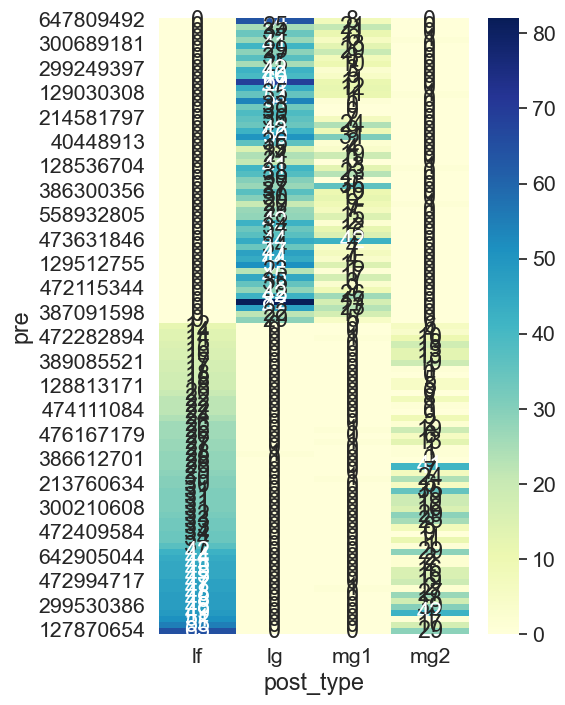

In [70]:
fig, axes = plt.subplots(1, figsize=(5,8))
sns.heatmap(data=df_map.sort_values(['lf']), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes)#[0])
# sns.heatmap(data=df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

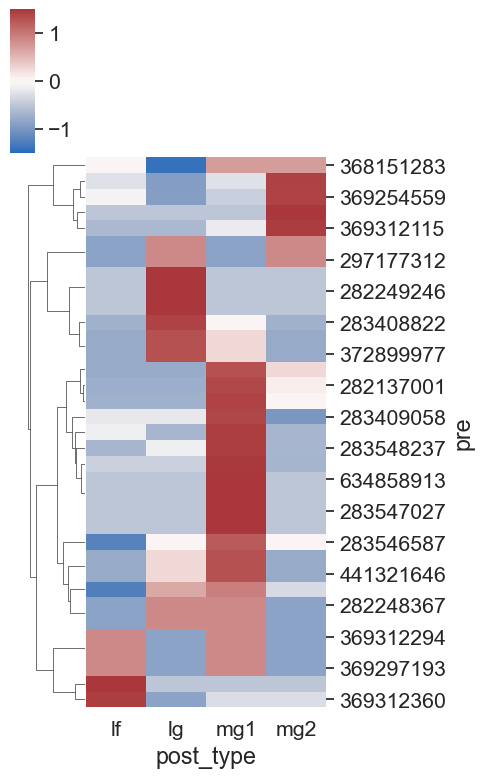

In [74]:

sns.set(font_scale=1.4)
sns.clustermap(data=df_map,z_score=0,cmap='vlag',col_cluster=False, vmin=-1.5, vmax=1.5,figsize=(5,8))

<AxesSubplot:xlabel='lf', ylabel='mg2'>

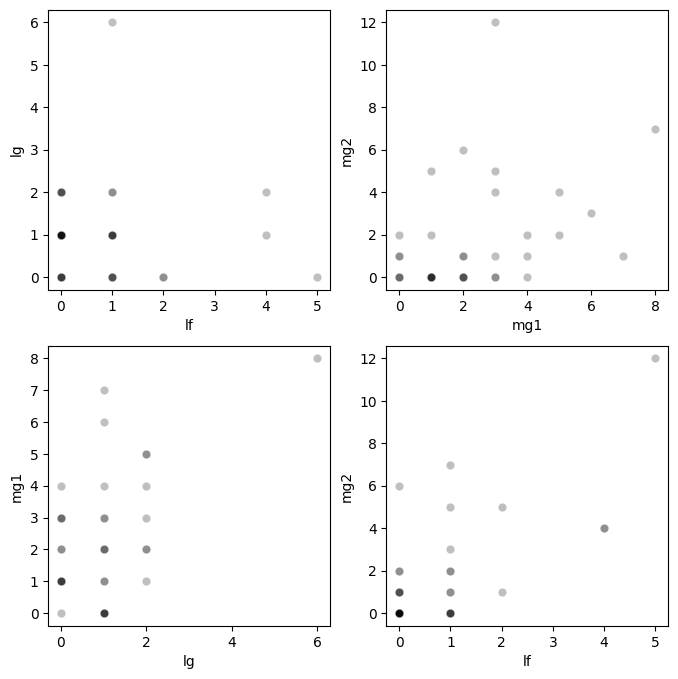

In [102]:
hfig,ax = plt.subplots(2,2,figsize=(8,8))
sns.scatterplot(df_map, x = 'lf', y = 'lg', ax = ax[0][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map, x = 'mg1', y = 'mg2', ax = ax[0][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map, x = 'lg', y = 'mg1', ax = ax[1][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map, x = 'lf', y = 'mg2', ax = ax[1][1],alpha = 0.25,color = 'black')

<AxesSubplot:xlabel='post_type', ylabel='pre'>

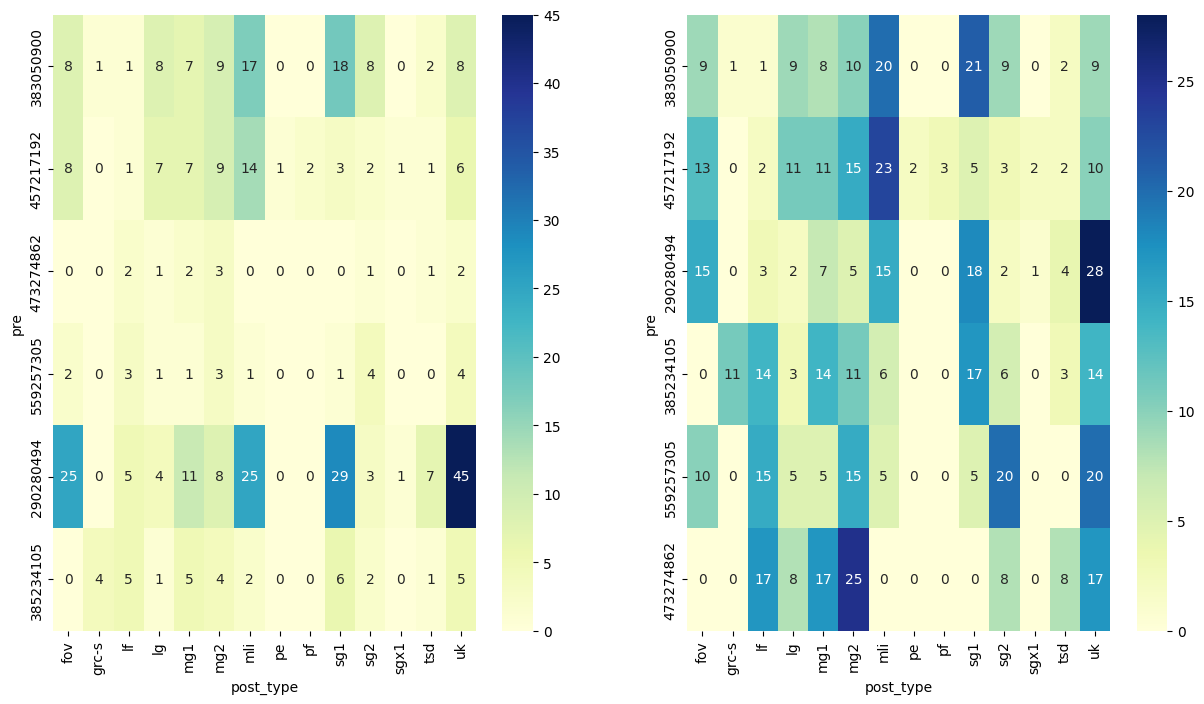

In [369]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
df_sorted = df_map.sort_values('lf')
sns.heatmap(data=df_sorted, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])
df_norm = df_sorted.div(df_sorted.sum(axis=1),axis=0).mul(100).round(0)
sns.heatmap(data=df_norm.sort_values('lf'), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

In [411]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'mli':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#ccccff',
    'uk':'#86592d',
    'fov':'#000000',
    'focal types':'#33cc33',
    'pf':'#ffcce6'
}

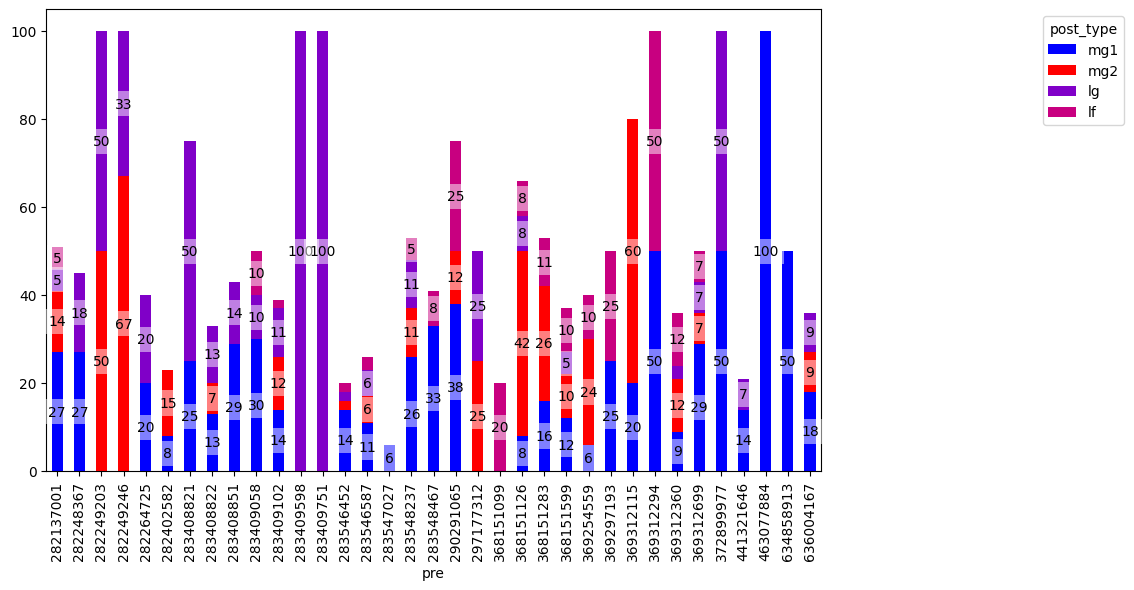

In [109]:
df_norm = df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0)

# order_pre = [383050900,457217192,290280494,385234105,559257305,473274862]
order_post = ['mg1','mg2','lg','lf']

# ax = pd.DataFrame(df_norm.loc[order_pre,order_post]).plot(kind='bar', stacked=True, figsize=(5, 6),color = syn_colors)
ax = pd.DataFrame(df_norm.loc[:,order_post]).plot(kind='bar', stacked=True, figsize=(10, 6),color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.4, 1))

### mean/total/proportion cells per type (collapse across rows within columns)

In [118]:
count_type = 'ncells' #'nsyn' #

types_ =  ['pf'] #df_edges['pre_type'].unique() # ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']#
df_map = pd.DataFrame()
for t in types_:
    if count_type == 'nsyn':
        df_grouped = df_edges[df_edges['pre_type']==t].groupby(
            ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
            index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    if count_type == 'ncells':
        df_grouped = df_edges[df_edges['pre_type']==t].groupby(
            ['pre','pre_type','post_type']).count().reset_index().pivot(
            index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)
df_map = df_map.set_index('pre')
df_map = df_map.drop(['pre_type'],axis=1)

In [119]:
df_map['output'] = df_map[['lf', 'lg']].sum(axis=1)
df_map['mg'] = df_map[['mg1', 'mg2']].sum(axis=1)
df_map['sg'] = df_map[['sg1', 'sg2']].sum(axis=1)

# Drop the original columns
df_map = df_map.drop(['lf', 'lg', 'mg1', 'mg2', 'sg1', 'sg2'], axis=1)

df_sum = df_map.sum()

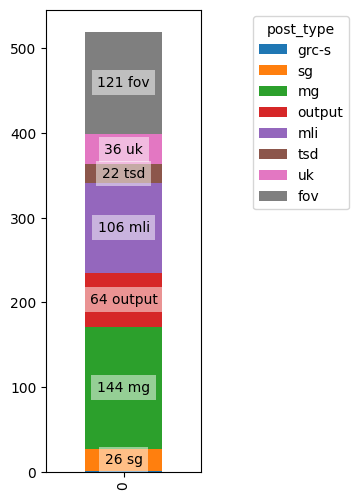

In [120]:
order_post = ['grc-s','sg','mg','output','mli','tsd','uk','fov']
df_sum_ordered = df_sum.loc[order_post]



ax = pd.DataFrame(df_sum_ordered).T.plot(kind='bar', stacked=True, figsize=(2, 6))#,color = syn_colors)

for p,cell_type in zip(ax.patches, order_post):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f} {cell_type}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(2, 1))

***Do this plot seperately for the set of pf originating from each example cell***

In [160]:
df_sum_ordered

post_type
grc-s       1.0
sg         26.0
mg        166.0
output     61.0
mli       115.0
tsd        24.0
pf          1.0
uk         42.0
fov       127.0
dtype: float64

In [126]:
df_map.sum() / df_map.sum().sum() * 100

post_type
fov       23.935091
grc-s      0.202840
mli       19.472617
pf         0.202840
tsd        4.462475
uk         7.707911
output    11.359026
mg        27.586207
sg         5.070994
dtype: float64

# Density and Proximity of connected cells

In [121]:
df_loc = pd.DataFrame.from_dict(soma_loc, orient='index', columns=['x', 'y', 'z']).dropna()
for c in df_loc.index:
    df_loc.loc[c,'type'] = cell_types[c]

NameError: name 'soma_loc' is not defined

In [229]:
df_loc.loc[df_loc['type'].isin(['mg1','mg2']),'type']='mg'
df_loc.loc[df_loc['type'].isin(['mg1','mg2']),'type']='output'

In [230]:
df_loc

x           y          z type
128614407  176.752031  264.280258  23.776078  sg1
480346174  273.944563  313.730172  75.376117   uk
301973569  387.064000  272.800000  47.760000   mg
43622486    59.805104  269.666914  16.534804   mg
386392158  240.488000  267.312000  56.355000   mg
...               ...         ...        ...  ...
127672247  262.412719  254.396906  25.799978  sg2
306585534  393.857312  295.699187  47.734711  sg1
214736845  281.279437  266.214844  35.405213  sg1
47194079   120.784000  290.564000   4.500000  sg2
128737253  226.952000  262.768000  18.375000   mg

[606 rows x 4 columns]

In [249]:
def euclidean_distance(df, cell_id1, cell_id2):
    if cell_id1 not in df.index or cell_id2 not in df.index:
        raise ValueError("Cell IDs not found in the DataFrame.")

    # Extract the coordinates for the two cell IDs
    coordinates1 = df.loc[cell_id1, ['x', 'y', 'z']]
    coordinates2 = df.loc[cell_id2, ['x', 'y', 'z']]

    # Check for NaN values in the coordinates
    if any(coordinates1.isna()) or any(coordinates2.isna()):
        raise ValueError("Coordinates contain NaN values.")

    # Calculate the Euclidean distance
    distance = np.linalg.norm(coordinates1 - coordinates2)

    return distance

In [256]:
# Example usage
# Assuming df is your DataFrame
distance = euclidean_distance(df_loc, 301973569, 43622486)
print("Euclidean distance:", distance)

Euclidean distance: 328.76011685595546


In [257]:
result_list = []

for i,r in df_edges.iterrows():
    
    
    try:
        df_edges.loc[i,'distance'] = euclidean_distance(df_loc, r['pre'], r['post'])
    except ValueError:
        df_edges.loc[i,'distance'] = np.NaN
# df_edges

In [261]:
df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()['pre']

pre       post post_type pre_type  weight   distance
20     41579854   49625293        lf      mg1       7  45.539296
42     41579854  393078033        lf      mg1      29  63.896908
48     41579854  479001172        lf      mg1      13  75.552030
51     41579854  481274292        lf      mg1       1  87.726946
74     42632020   49453764        lf      mg1       6  49.618838
...         ...        ...       ...      ...     ...        ...
5682  558300217  301787806        lg      mg2       3  54.309460
5686  558300217  474898913        lg      mg2       3  90.814376
5687  558300217  560681683        lg      mg2       9  43.582935
5688  558360429  393325331        lf      mg1       2  79.829452
5702  558932805  388406692        lg      mg2      21  33.550537

[204 rows x 6 columns]

array([[<AxesSubplot:title={'center':'pre'}>,
        <AxesSubplot:title={'center':'post'}>],
       [<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'distance'}>]], dtype=object)

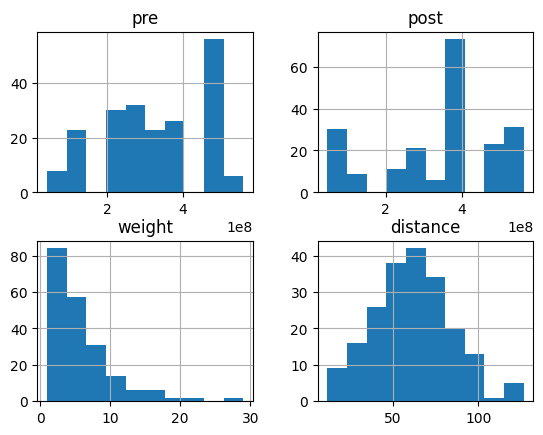

In [262]:
df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna().hist()

In [299]:
sub_df = df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()

<AxesSubplot:xlabel='distance', ylabel='weight'>

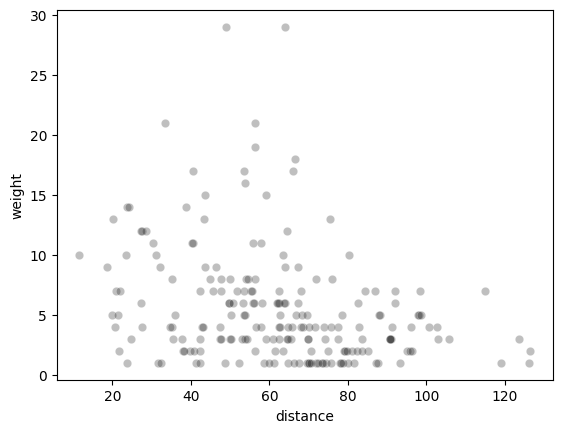

In [302]:
sns.scatterplot(sub_df, x='distance',y='weight',color='black',alpha = 0.25)

In [284]:
def combine_neurons(df_edges, combine='post'):
    if combine not in ['pre', 'post']:
        raise ValueError("Combine must be either 'pre' or 'post'.")

    # Select columns based on combine parameter
    group_cols = ['pre'] if combine == 'post' else ['post']
    value_cols = ['weight', 'distance']

    # Group by the selected columns and calculate mean and standard deviation
    result_df = df_edges.groupby(group_cols)[value_cols].agg(['mean', 'std']).reset_index()

    # Rename columns for better readability
    result_df.columns = ['_'.join(col).strip() for col in result_df.columns.values]

    return result_df

In [296]:
# do the analysis on the subset of the df for which 
# the pre is an mg, the post is an output, and the location of both somas is known
sub_df = df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()

result_df = combine_neurons(sub_df, combine='post')

result_df.head(5)

pre_  weight_mean  weight_std  distance_mean  distance_std
0   41579854    12.500000   12.041595      68.178795     17.957137
1   42632020     3.333333    2.516611      61.656555     12.418550
2   43622486    15.000000         NaN      59.086083           NaN
3  126618353     1.500000    0.707107      85.424238     13.661970
4  127870654     6.000000    2.121320      76.540455     19.984571

<AxesSubplot:ylabel='distance_mean'>

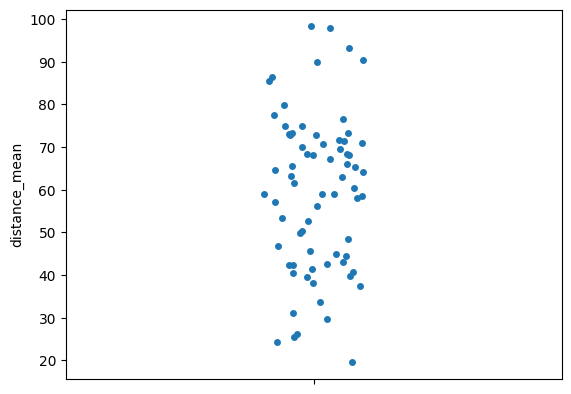

In [297]:
sns.stripplot(result_df,y='distance_mean')

Text(0, 0.5, 'n mg cells')

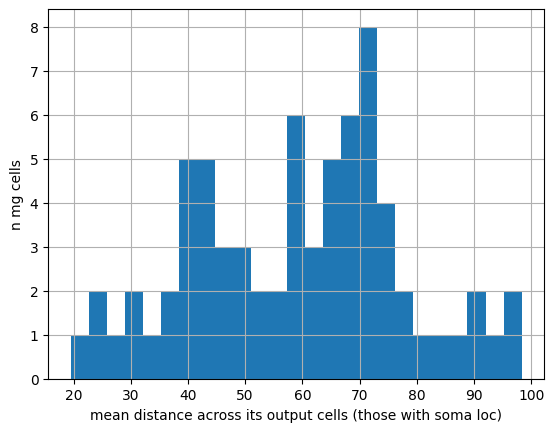

In [311]:
ax = result_df['distance_mean'].hist(bins=25)

ax.set_xlabel('mean distance across its output cells (those with soma loc)')
ax.set_ylabel('n mg cells')


<AxesSubplot:xlabel='distance_mean', ylabel='weight_mean'>

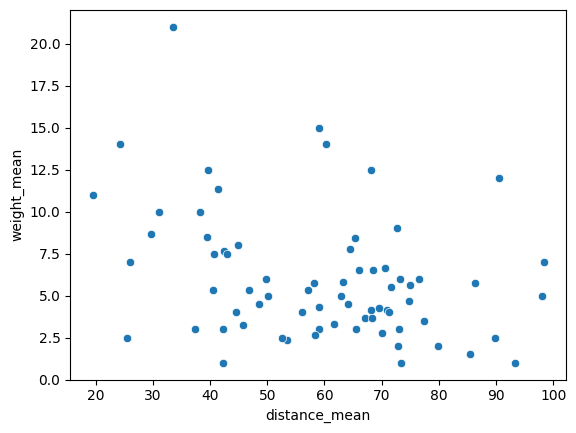

In [298]:
sns.scatterplot(result_df,x='distance_mean',y='weight_mean')

In [312]:
# do the analysis on the subset of the df for which 
# the pre is an mg, the post is an output, and the location of both somas is known
sub_df = df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()

result_df = combine_neurons(sub_df, combine='pre')

result_df.head(5)

post_  weight_mean  weight_std  distance_mean  distance_std
0  45633163    14.000000         NaN      23.847896           NaN
1  48573302     5.200000    2.949576      66.320505     15.251722
2  48929295     2.800000    2.683282      73.125271     14.566075
3  49453764     3.900000    2.685351      78.045915     25.870017
4  49625293     3.555556    2.006932      77.923535     22.324786

Text(0, 0.5, 'n output cells')

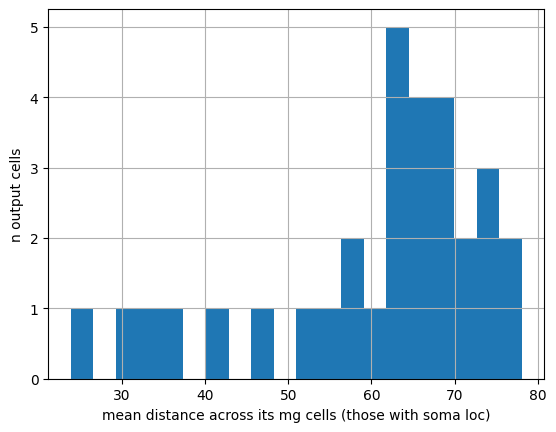

In [314]:
ax = result_df['distance_mean'].hist(bins=20)

ax.set_xlabel('mean distance across its mg cells (those with soma loc)')
ax.set_ylabel('n output cells')

# cluster map

In [18]:
types_ =  ['mg1','mg2']#df_edges['pre_type'].unique() # ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']#
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    # df_grouped = df_edges[df_edges['pre_type']==t].groupby(
    #     ['pre','pre_type','post_type']).count().reset_index().pivot(
    #     index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    

    
df_map = df_map.fillna(0)

df_map = df_map.set_index('pre')

In [19]:
tmp_type = pd.DataFrame(df_map['pre_type'])

In [20]:
df_map = df_map.drop(['pre_type'],axis=1)

# data_df = df_map[df_edges['post_type'].unique()].div(df_map[df_edges['post_type'].unique()].sum(axis=1),axis=0).mul(100).round(0)
data_df = df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0)
# data_df.loc[:,'pre_type']=tmp_type

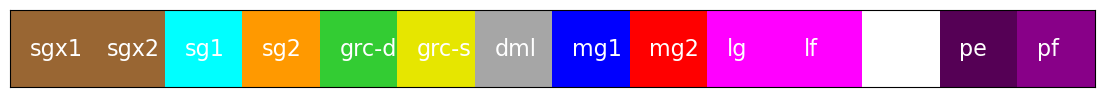

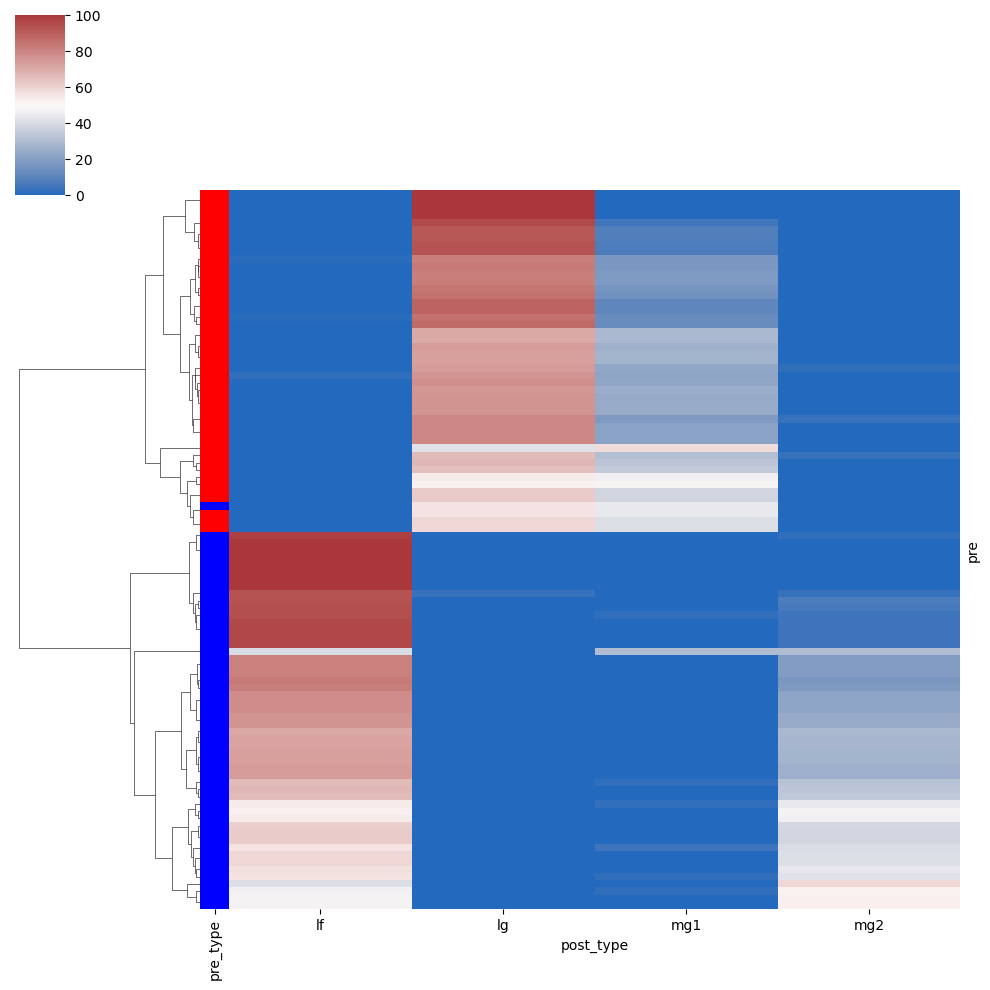

In [21]:
labels = tmp_type['pre_type'].unique()#df_map['pre_type'].unique()
color_pal = sns.color_palette("deep", len(labels))

color_dict = {
    'sgx1':'#996633',
    'sgx2':'#996633',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#a6a6a6',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#ff00ff',
    'lf':'#ff00ff',
    'aff':'#ffffff',
    'pe':'#550055',
    'pf':'#880088'
}
sns.palplot(color_dict.values())
ax = plt.gca()
ax.tick_params(left=False, bottom=False)

for i,v in enumerate(color_dict):
    ax.text(i-0.25, 0.1, v,fontsize=16,color='white') 


sns.clustermap(data = data_df,
               method='average',
               col_cluster=False, cmap="vlag", center=50,yticklabels=False,
               row_colors = tmp_type['pre_type'].map(color_dict));

# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap="YlGnBu", yticklabels=False,
#                row_colors = tmp_type['pre_type'].map(color_dict));

# data_df = df_map[df_edges['post_type'].unique()]
# cmap = sns.color_palette("blend:#d9d9d9,#000000", as_cmap=True)
# cmap.set_under('white')
# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap=cmap, vmin=1, yticklabels=False,
#                row_colors = df_map['pre_type'].map(color_dict));


# The methods are single, complete, average, weighted, ward, median, centroid
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
# default for seaborn is "average"

# CDF

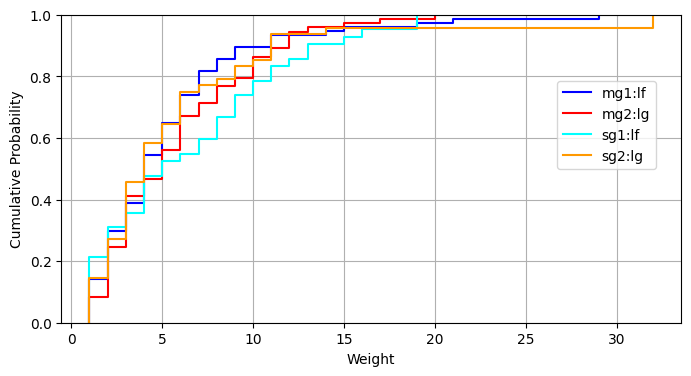

In [227]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['mg1','sg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'])
    if (pre_type in ['mg2','sg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'])
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

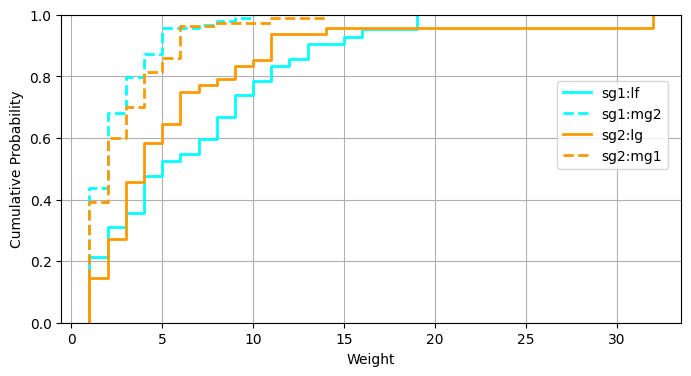

In [228]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['sg1']) & (post_type in ['mg2']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['sg2']) & (post_type in ['mg1']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['sg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    if (pre_type in ['sg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

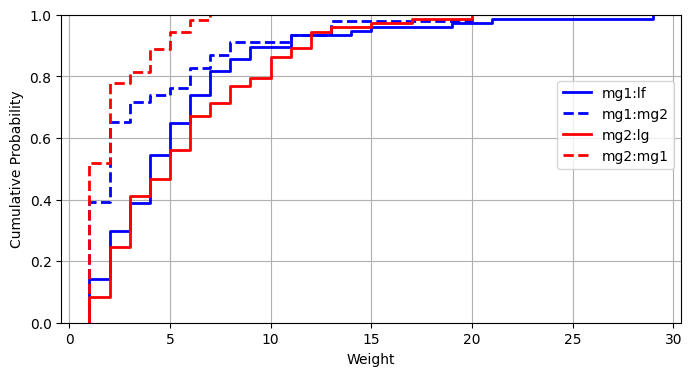

In [229]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['mg1']) & (post_type in ['mg2']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['mg2']) & (post_type in ['mg1']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['mg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    if (pre_type in ['mg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

# Distribution of weights by type

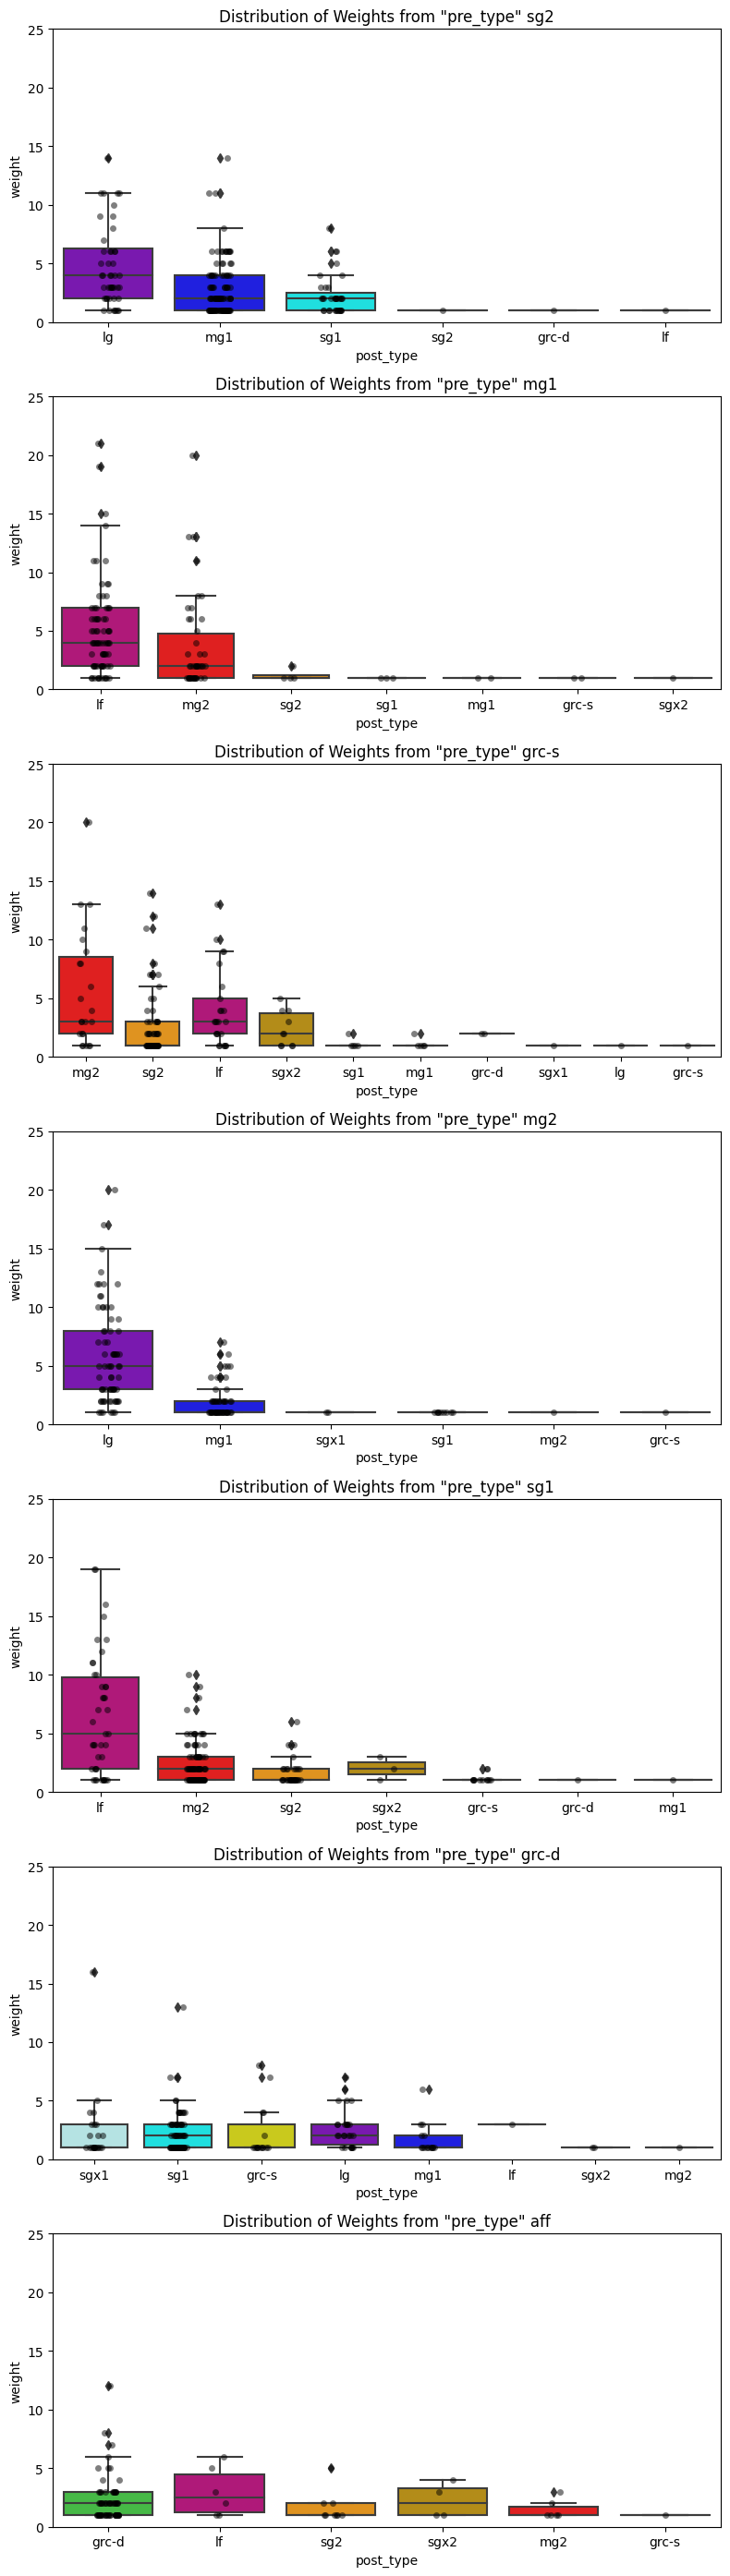

In [1833]:
# df= df_edges[(df_edges['pre_type'].isin(['sg1','sg2','mg1','mg2'])) & (df_edges['post_type'].isin(['mg1','mg2','lf','lg']))]

fig, axes = plt.subplots(len(df_edges['pre_type'].unique()), 1, figsize=(8, 4 * len(df_edges['pre_type'].unique())))

for i,p in enumerate(df_edges['pre_type'].unique()):

    sns.boxplot(data=df_edges[df_edges['pre_type'] == p], x='post_type', y='weight', ax=axes[i],palette=syn_colors)#, inner='quartile', palette='Set2')
    sns.stripplot(data=df_edges[df_edges['pre_type'] == p], x='post_type', y='weight', ax=axes[i],color='black',alpha=0.5)
    axes[i].set_title(f'Distribution of Weights from "pre_type" {p}')
    axes[i].set_ylim(0,25)

plt.tight_layout()
plt.show()